# CYGNSS CD Summary Figures

Plots copied from original IV and TC notebooks (processing unchanged, imports consolidated).

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.spatial import cKDTree
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import get_cmap

# repo utilities

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'plotting'))
sys.path.append(str(repo_root / 'common' / 'python' / 'io'))
sys.path.append(str(repo_root / 'projects' / 'matlab2python' / 'shared' / 'python'))
sys.path.append('../util/shared/python/')

from geospatial_plotting import plot_region, REGION_BOUNDS, load_ease_grid, build_ease_grid_mapping
from read_GEOSldas import read_tilecoord

DATA_DIR = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data')


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.spatial import cKDTree
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import get_cmap

# repo utilities

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'plotting'))
sys.path.append(str(repo_root / 'common' / 'python' / 'io'))
sys.path.append(str(repo_root / 'projects' / 'matlab2python' / 'shared' / 'python'))
sys.path.append('../util/shared/python/')

from geospatial_plotting import plot_region, REGION_BOUNDS
from read_GEOSldas import read_tilecoord

DATA_DIR = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data')


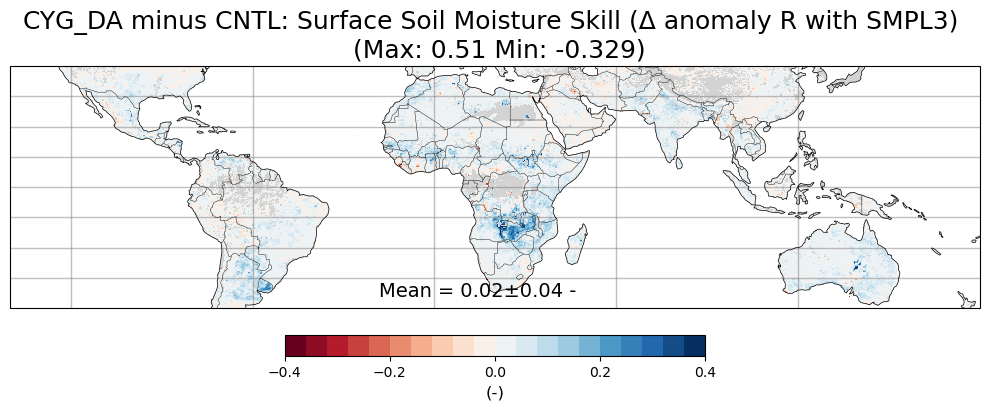

In [3]:
# Open .mat files
data = sio.loadmat('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/IVs/Rdiff_DAv8_M36_cd_minus_OLv8_M36_cd_SMPL3.mat')

# Get the data from the .mat file which contains 3 variables, Rdiff_vector, lons, lats
Rdiff_vector_smp = np.squeeze(data['Rdiff_vector'])
lons = np.squeeze(data['lons'])
lats = np.squeeze(data['lats'])

map_array = np.empty([len(lons), 3])
map_array.fill(np.nan)
map_array[:, 1] = lons
map_array[:, 2] = lats
map_array[:, 0] = Rdiff_vector_smp

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])


# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CYG_DA minus CNTL: Surface Soil Moisture Skill (Δ anomaly R with SMPL3) \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='-',
    cmin=-0.4,
    cmax=0.4,
    cmap='RdBu'
)
fig.tight_layout()

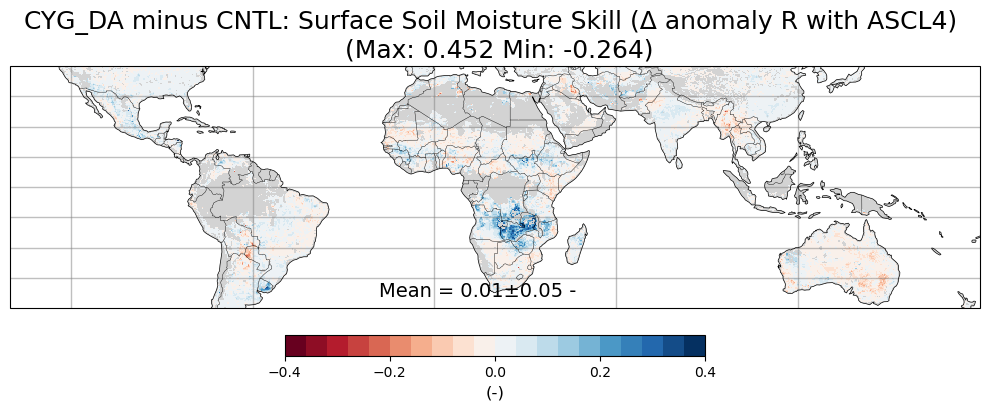

In [4]:
# Open .mat files
data = sio.loadmat('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/IVs/Rdiff_DAv8_M36_cd_minus_OLv8_M36_cd_ASCL4.mat')

# Get the data from the .mat file which contains 3 variables, Rdiff_vector, lons, lats
Rdiff_vector_asc = np.squeeze(data['Rdiff_vector'])
lons = np.squeeze(data['lons'])
lats = np.squeeze(data['lats'])

map_array = np.empty([len(lons), 3])
map_array.fill(np.nan)
map_array[:, 1] = lons
map_array[:, 2] = lats
map_array[:, 0] = Rdiff_vector_asc

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])


# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CYG_DA minus CNTL: Surface Soil Moisture Skill (Δ anomaly R with ASCL4) \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='-',
    cmin=-0.4,
    cmax=0.4,
    cmap='RdBu'
)
fig.tight_layout()

In [5]:

# --------- 1) paths ---------
p_cntl = Path("/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/IVs/ASCL4_SMPL3_OLv8_M36_cd_TC_stats_201808_202405.mat")
p_da   = Path("/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/IVs/ASCL4_SMPL3_DAv8_M36_cd_TC_stats_201808_202405.mat")

# --------- 2) load .mat (squeeze to 1D vectors) ---------
def _vec(x):
    return np.asarray(x).squeeze()

M0 = loadmat(p_cntl, squeeze_me=True, struct_as_record=False)
M1 = loadmat(p_da,   squeeze_me=True, struct_as_record=False)

In [6]:

# expected vars: 'lons','lats','N_sm','Nmin','R2_TC_L3','R2_TC_ASC','R2_TC_mod',
# 'sigma2_L3','sigma2_mod','sigma2_ASC','R_mod_L3','R_mod_ASC','R_ASC_L3',
# 'C_L3_mod','C_mod_ASC','C_L3_ASC'

def _vec(x): return np.asarray(x).squeeze()

def grab(M, name):
    if name not in M:
        raise KeyError(f"Missing '{name}' in file")
    return _vec(M[name])

# --- grid shape from lons/lats ---
lons = grab(M0, "lons")
lats = grab(M0, "lats")

if lons.ndim == 2 and lats.ndim == 2:
    shp = lons.shape  # (nlon, nlat)
else:
    # If saved flat, set to your grid dims and reshape
    nlon, nlat = 406, 964
    shp = (nlon, nlat)
    lons = lons.reshape(shp)
    lats = lats.reshape(shp)

    # preserve TC grid as flat vectors
    lons_tc = lons.flatten()
    lats_tc = lats.flatten()

# Helpers to coerce arrays to 2D grid
def as_grid(M, key, shp):
    a = grab(M, key)
    if a.ndim == 2 and a.shape == shp:
        return a
    if a.size == np.prod(shp):
        return a.reshape(shp)
    # Some MATLAB saves may come as (nlat, nlon); handle simple transpose case
    if a.ndim == 2 and a.shape == (shp[1], shp[0]):
        return a.T
    raise ValueError(f"Field '{key}' has unexpected shape {a.shape}, cannot map to {shp}")

def get_fields(M, shp):
    grid_keys = [
        "N_sm",
        "R2_TC_L3","R2_TC_ASC","R2_TC_mod",
        "sigma2_L3","sigma2_mod","sigma2_ASC",
        "R_mod_L3","R_mod_ASC","R_ASC_L3",
        "C_L3_mod","C_mod_ASC","C_L3_ASC",
    ]
    out = {k: as_grid(M, k, shp) for k in grid_keys}
    # Scalars
    out["Nmin"] = float(grab(M, "Nmin"))
    return out

S0 = get_fields(M0, shp)  # CNTL
S1 = get_fields(M1, shp)  # CYG_DA


In [7]:

# --------- 3) build common-valid mask ---------
# same sampling threshold in both + all fields finite where needed
Nmin = int(np.nanmax(S0["Nmin"]))  # should be same value
Mvalid = (
    (S0["N_sm"] >= Nmin) & (S1["N_sm"] >= Nmin) &
    np.isfinite(S0["R2_TC_mod"]) & np.isfinite(S1["R2_TC_mod"]) &
    np.isfinite(S0["sigma2_mod"]) & np.isfinite(S1["sigma2_mod"])
)

# clamp any R2 slightly outside (0,1] due to rounding
def clamp01(a):
    out = a.copy()
    out[(out <= 0) | (~np.isfinite(out))] = np.nan
    out[out > 1] = 1.0
    return out

R2m0 = clamp01(S0["R2_TC_mod"])
R2m1 = clamp01(S1["R2_TC_mod"])


In [8]:

# --------- 4) compute metrics ---------
# (a) change in R^2 (positive is better)
dR2_mod = np.where(Mvalid, R2m1 - R2m0, np.nan)
pct_R2 = np.where(Mvalid, 100.0*(R2m1/R2m0 - 1), np.nan)  # positive % is better

def robust_sigma_t2(S, tol=1e-12, max_spread=50.0):
    C_l3m  = S["C_L3_mod"].astype(float)
    C_ma   = S["C_mod_ASC"].astype(float)
    C_l3a  = S["C_L3_ASC"].astype(float)

    # three TC permutations for σ_t^2
    s1 = (C_l3m * C_ma)  / C_l3a
    s2 = (C_l3m * C_l3a) / C_ma
    s3 = (C_ma  * C_l3a) / C_l3m
    stack = np.stack([s1, s2, s3], 0)

    # basic validity: finite and positive
    valid = np.isfinite(stack) & (stack > tol)
    sig_t2 = np.nanmedian(np.where(valid, stack, np.nan), axis=0)

    # consistency check: drop pixels where permutations disagree wildly
    smin = np.nanmin(np.where(valid, stack, np.nan), axis=0)
    smax = np.nanmax(np.where(valid, stack, np.nan), axis=0)
    spread = smax / smin
    bad = (~np.isfinite(sig_t2)) | (sig_t2 <= tol) | (~np.isfinite(spread)) | (spread > max_spread)
    sig_t2[bad] = np.nan
    return sig_t2

def direct_fMSE(S):
    """
    Compute fractional MSE directly from TC covariances & error variances.
    S must contain: 'sigma2_mod','sigma2_L3','sigma2_ASC',
                    'C_L3_mod','C_mod_ASC','C_L3_ASC'
    Returns: dict with fMSE_{mod,L3,ASC} and sigma_t2.
    """
    C_L3_mod = S["C_L3_mod"].astype(float)
    C_mod_ASC= S["C_mod_ASC"].astype(float)
    C_L3_ASC = S["C_L3_ASC"].astype(float)

    # Truth (signal) variance from TC geometry
    sigma_t2 = robust_sigma_t2(S)

    bad = (~np.isfinite(sigma_t2)) | (sigma_t2 <= 0)
    fMSE_mod = np.full_like(sigma_t2, np.nan)
    fMSE_L3  = np.full_like(sigma_t2, np.nan)
    fMSE_ASC = np.full_like(sigma_t2, np.nan)

    ok = ~bad
    # Require finite σ² as well
    ok_mod = ok & np.isfinite(S["sigma2_mod"])
    ok_L3  = ok & np.isfinite(S["sigma2_L3"])
    ok_ASC = ok & np.isfinite(S["sigma2_ASC"])

    fMSE_mod[ok_mod] = S["sigma2_mod"][ok_mod] / sigma_t2[ok_mod]
    fMSE_L3[ok_L3]   = S["sigma2_L3"][ok_L3]   / sigma_t2[ok_L3]
    fMSE_ASC[ok_ASC] = S["sigma2_ASC"][ok_ASC] / sigma_t2[ok_ASC]

    # Nonphysical negatives -> NaN
    fMSE_mod[fMSE_mod < 0] = np.nan
    fMSE_L3[fMSE_L3   < 0] = np.nan
    fMSE_ASC[fMSE_ASC < 0] = np.nan

    return dict(fMSE_mod=fMSE_mod, fMSE_L3=fMSE_L3, fMSE_ASC=fMSE_ASC, sigma_t2=sigma_t2)


def fMSE_from_R2(R2):
    fm = (1 - R2) / R2
    fm[(~np.isfinite(fm)) | (fm < 0)] = np.nan
    return fm

# Example usage on your loaded fields S0/S1 (CNTL/DA):
direct0 = direct_fMSE(S0); direct1 = direct_fMSE(S1)
fMSE0_R2 = fMSE_from_R2(S0["R2_TC_mod"])
diff_check = np.nanmax(np.abs(direct0["fMSE_mod"] - fMSE0_R2))
print("max |direct - via R2|:", diff_check)


# fMSE0 = fMSE_from_R2(R2m0)
# fMSE1 = fMSE_from_R2(R2m1)
# dfMSE = np.where(Mvalid, fMSE1 - fMSE0, np.nan)              # negative is good
# pct_fMSE = np.where(Mvalid, 100.0*(fMSE1/fMSE0 - 1), np.nan) # negative % is good

# Direct fMSE from TC covariances
direct0 = direct_fMSE(S0)   # CNTL
direct1 = direct_fMSE(S1)   # CYG_DA

fMSE0 = direct0["fMSE_mod"]
fMSE1 = direct1["fMSE_mod"]

# Valid where both runs have finite fMSE and you already had Nmin, etc.
Mvalid_fmse = Mvalid & np.isfinite(fMSE0) & np.isfinite(fMSE1)

dfMSE = np.full_like(fMSE0, np.nan)
dfMSE[Mvalid_fmse] = fMSE1[Mvalid_fmse] - fMSE0[Mvalid_fmse]      # negative is good

pct_fMSE = np.full_like(fMSE0, np.nan)
ratio = np.full_like(fMSE0, np.nan)
ratio[Mvalid_fmse] = fMSE1[Mvalid_fmse] / fMSE0[Mvalid_fmse]
pct_fMSE[Mvalid_fmse] = 100.0 * (ratio[Mvalid_fmse] - 1.0)        # negative % is good

# (c) change in model error variance (σ^2_mod) and % change
sig20 = S0["sigma2_mod"]; sig21 = S1["sigma2_mod"]
dsig2 = np.where(Mvalid, sig21 - sig20, np.nan)                  # negative is good

# 1) mask tiny baseline sigma2 before % change
p10 = np.nanpercentile(sig20, 10)
baseline_floor = max(1e-8, p10)
good_base = Mvalid & np.isfinite(sig20) & (sig20 > baseline_floor)

pct_sig2 = np.full_like(sig20, np.nan)
pct_sig2[good_base] = 100.0 * (sig21[good_base]/sig20[good_base] - 1.0)

# 2) Robust summaries (don’t use mean±std)
def robust_summary(a, m):
    x = a[m & np.isfinite(a)]
    if x.size == 0: return {"median": np.nan, "IQR": np.nan, "n": 0, "improved_frac": np.nan}
    q25, q50, q75 = np.nanpercentile(x, [25, 50, 75])
    return {
        "median": float(q50),
        "IQR": float(q75 - q25),
        "n": int(x.size),
        "improved_frac": float(np.nanmean((x < 0)))  # negative % = reduction
    }

summ_pct = robust_summary(pct_sig2, good_base)
summ_dR2 = robust_summary(dR2_mod, Mvalid)

print("ΔR²_mod  (median, IQR):", summ_dR2["median"], summ_dR2["IQR"])
print("Fraction tiles with R² improved:", 1 - summ_dR2["improved_frac"])
print("%Δσ²_mod (median, IQR):", summ_pct["median"], summ_pct["IQR"])
print("Fraction tiles with σ² reduced:", summ_pct["improved_frac"])


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/772074.py:19: RuntimeWarning: All-NaN slice encountered
  sig_t2 = np.nanmedian(np.where(valid, stack, np.nan), axis=0)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/772074.py:22: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(np.where(valid, stack, np.nan), axis=0)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/772074.py:23: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(np.where(valid, stack, np.nan), axis=0)


max |direct - via R2|: 81.23483281656671
ΔR²_mod  (median, IQR): 0.027107037882334206 0.05961117215005787
Fraction tiles with R² improved: 0.8732165206508136
%Δσ²_mod (median, IQR): -22.21177618779765 21.248819168271133
Fraction tiles with σ² reduced: 0.9537554747926568


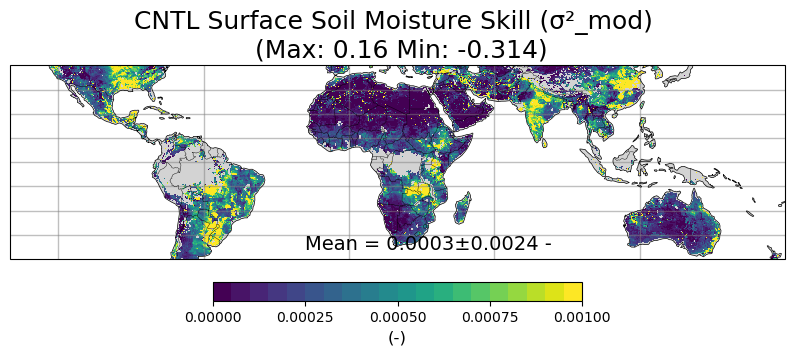

In [9]:
map_array = np.full((lons.size, 3), np.nan)
map_array[:, 1] = lons.flatten()
map_array[:, 2] = lats.flatten()

sig_cntl = S0["sigma2_mod"].flatten()
map_array[:, 0] = sig_cntl

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CNTL Surface Soil Moisture Skill (σ²_mod) \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='-',
    cmin=-0.00,
    cmax=0.001
)


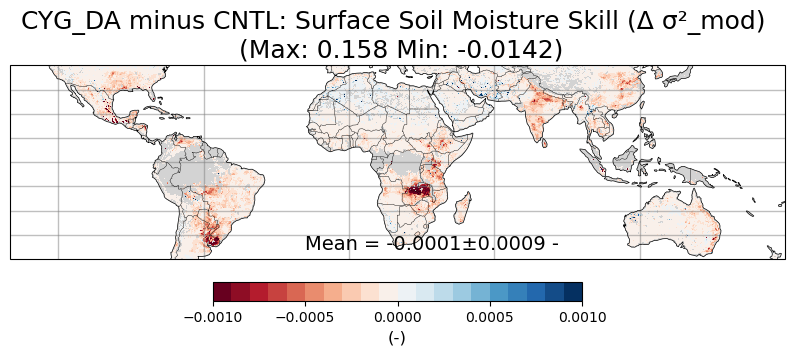

In [10]:

map_array = np.full((lons.size, 3), np.nan)
map_array[:, 1] = lons.flatten()
map_array[:, 2] = lats.flatten()



dsig2_vec = dsig2.flatten()
map_array[:, 0] = dsig2_vec

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CYG_DA minus CNTL: Surface Soil Moisture Skill (Δ σ²_mod) \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='-',
    cmin=-0.001,
    cmax=0.001,
    cmap='RdBu'
)

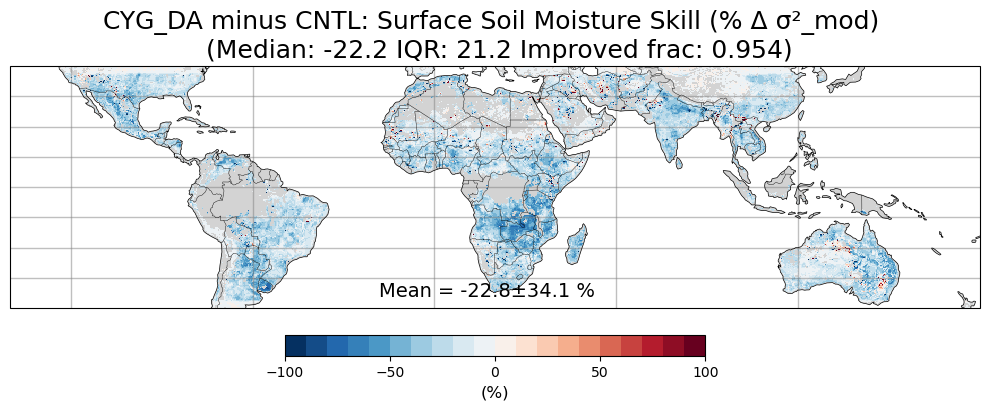

In [11]:
pct_sig2_vec = pct_sig2.flatten()

pct_sig2_plot = pct_sig2_vec.copy()

lo, hi = np.nanpercentile(pct_sig2_vec, [1, 99])
# pct_sig2_plot = np.clip(pct_sig2_vec, lo, hi)

map_array[:, 0] = pct_sig2_plot

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CYG_DA minus CNTL: Surface Soil Moisture Skill (% Δ σ²_mod) \n (Median: {summ_pct["median"]:.3g} IQR: {summ_pct["IQR"]:.3g} Improved frac: {summ_pct["improved_frac"]:.3g})',
    units='%',
    cmin=-100.0,
    cmax=100.0,
    cmap='RdBu_r'
)
fig.tight_layout()

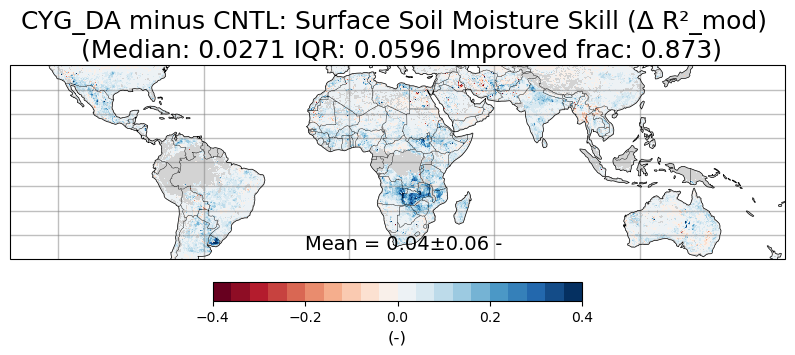

In [12]:
dR2_mod_vec = dR2_mod.flatten()
map_array[:, 0] = dR2_mod_vec

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CYG_DA minus CNTL: Surface Soil Moisture Skill (Δ R²_mod) \n (Median: {summ_dR2["median"]:.3g} IQR: {summ_dR2["IQR"]:.3g} Improved frac: {1 -summ_dR2["improved_frac"]:.3g})',
    units='-',
    cmin=-0.4,
    cmax=0.4,
    cmap='RdBu'
)

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3421434697.py:16: RuntimeWarning: invalid value encountered in sqrt
  map_array[:, 0] = np.sqrt(sigma2_CYG)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3421434697.py:33: RuntimeWarning: invalid value encountered in sqrt
  map_array[:, 0] = np.sqrt(sigma2_L3)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3421434697.py:50: RuntimeWarning: invalid value encountered in sqrt
  map_array[:, 0] = (np.sqrt(sigma2_ASC))
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3421434697.py:66: RuntimeWarning: invalid value encountered in sqrt
  map_array[:, 0] = (np.sqrt(sigma2_ASC)) * 200


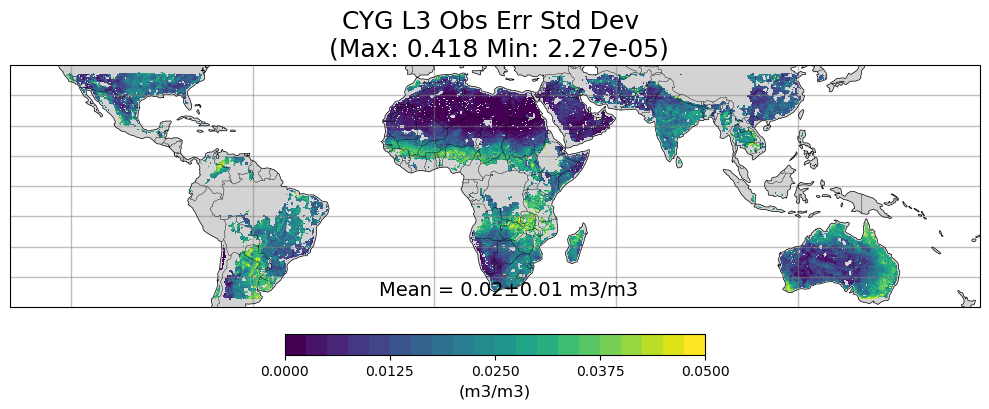

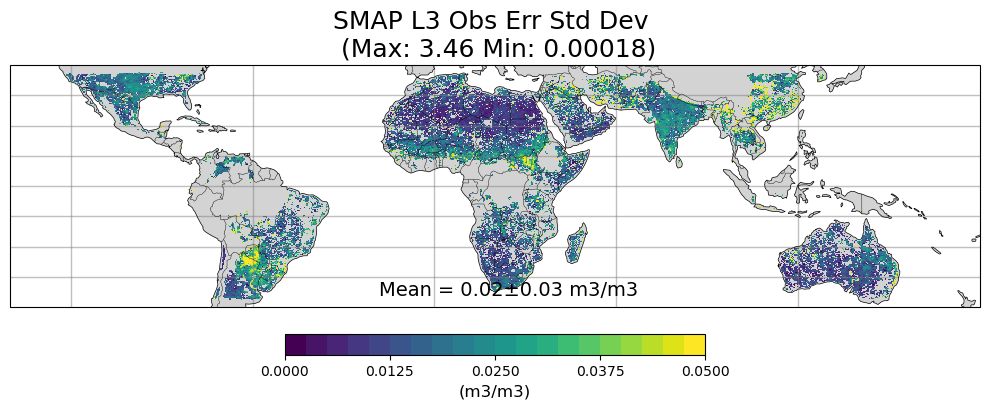

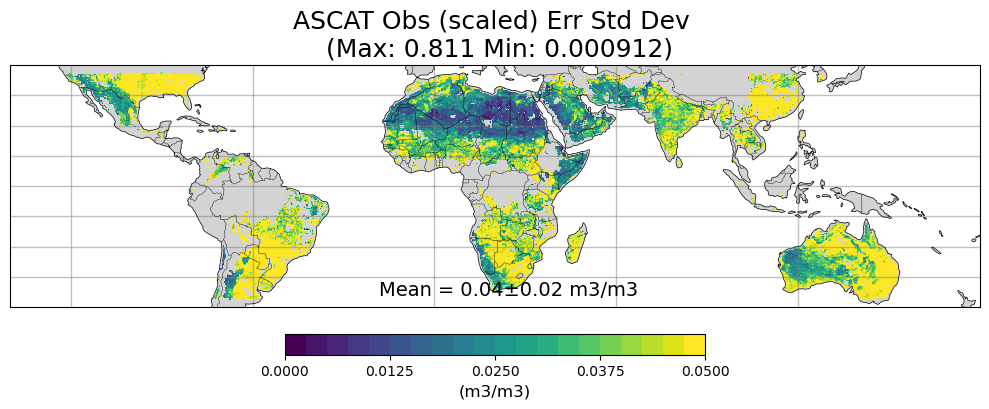

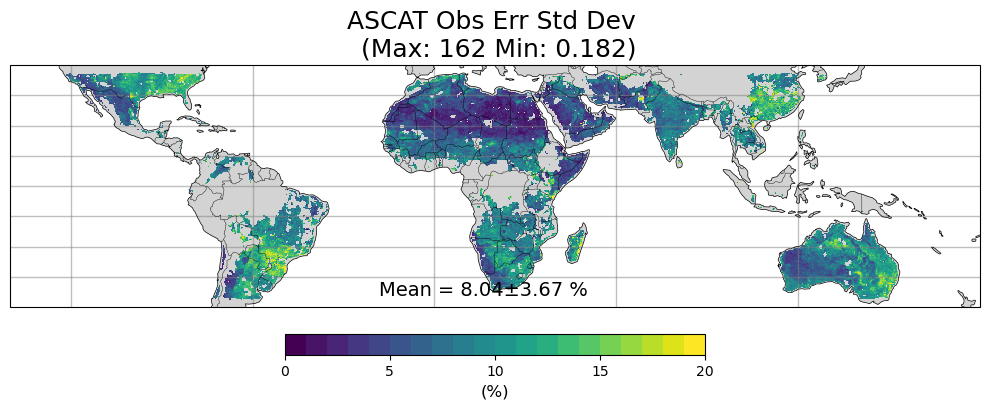

In [13]:
p_tc_obs   = Path("/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/IVs/ASCL4_SMPL3_CYGL3_OLv8_M36_cd_TC_stats_201808_202405.mat")
M2 = loadmat(p_tc_obs, squeeze_me=True, struct_as_record=False)

# --- grid shape from lons/lats ---
lons = grab(M2, "lons")
lats = grab(M2, "lats")
sigma2_CYG = grab(M2, "sigma2_CYG")
sigma2_L3 = grab(M2, "sigma2_L3")
sigma2_ASC = grab(M2, "sigma2_ASC")

map_array = np.empty([len(lons), 3])
map_array.fill(np.nan)
map_array[:, 1] = lons
map_array[:, 2] = lats

map_array[:, 0] = np.sqrt(sigma2_CYG)

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CYG L3 Obs Err Std Dev \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='m3/m3',
    cmin=0.00,
    cmax=0.05
)
fig.tight_layout()

map_array[:, 0] = np.sqrt(sigma2_L3)

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'SMAP L3 Obs Err Std Dev \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='m3/m3',
    cmin=0.00,
    cmax=0.05
)
fig.tight_layout()

map_array[:, 0] = (np.sqrt(sigma2_ASC))
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'ASCAT Obs (scaled) Err Std Dev \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='m3/m3',
    cmin=0.00,
    cmax=0.05
)
fig.tight_layout()

map_array[:, 0] = (np.sqrt(sigma2_ASC)) * 200
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'ASCAT Obs Err Std Dev \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='%',
    cmin=0.00,
    cmax=20.0
)
fig.tight_layout()

In [14]:
# Load aridity/LAI dataset
fn = DATA_DIR / 'CYGNSS_Experiments/Evaluation/IVs/aridity_indices_model_net_rad_20180801_20240630.nc4'
ds = xr.open_dataset(fn, decode_times=True)
ai = ds['AI_clim'].values
lon = ds['lon'].isel(time=1).values
lat = ds['lat'].isel(time=1).values
mean_lai_clim = ds['mean_lai_clim'].values
mean_greeness_clim = ds['mean_greeness_clim'].values if 'mean_greeness_clim' in ds else None
title_time = 'Climatology'


AI_clim Climatology max 6.19 min 0.00047


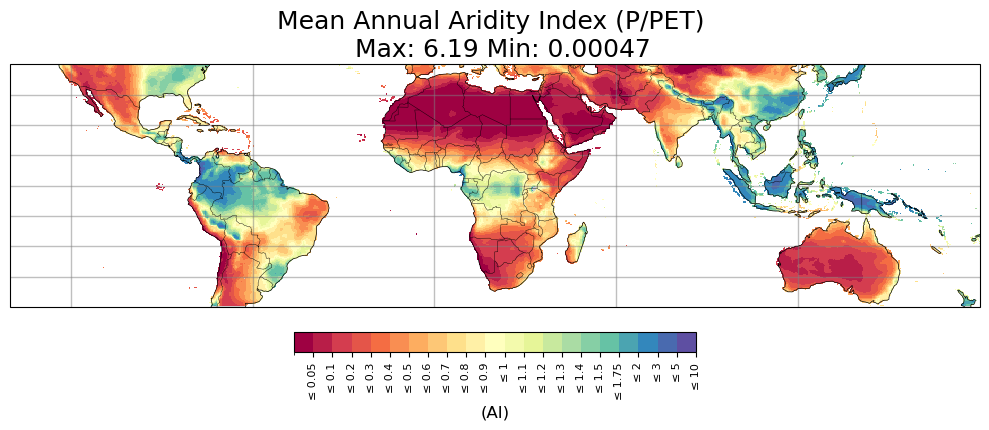

In [15]:
ai_flat = np.squeeze(ai)
lon_flat = np.squeeze(lon)
lat_flat = np.squeeze(lat)
n = ai_flat.size

pred_lon_flat = lon_flat
pred_lat_flat = lat_flat

map_array = np.empty((n, 3), dtype=float)
map_array.fill(np.nan)
map_array[:, 0] = ai_flat
map_array[:, 1] = lon_flat
map_array[:, 2] = lat_flat

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

print(f"AI_clim {title_time} max {maxval:.3g} min {minval:.3g}")

# 21 bin edges (same thresholds as the legend)
ai_edges = np.array([
    0.00, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60,
    0.70, 0.80, 0.90, 1.00, 1.10, 1.20, 1.30, 1.40,
    1.50, 1.75, 2.00, 3.00, 5.00, 10.00
])

# --- Example usage with an array 'AI' (same shape as your map) --
# Create a colormap with 20 colors (one for each bin)
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=False,
    plot_title=f"Mean Annual Aridity Index (P/PET) \n  Max: {maxval:.3g} Min: {minval:.3g}",
    units='AI',
    cmin=0,
    cmax=0.6,
    discrete_edges=ai_edges,     # <<< turn on discrete Spectral
    base_cmap="Spectral"
)
fig.tight_layout()
plt.show()

mean_lai_clim max 5.73 min 0


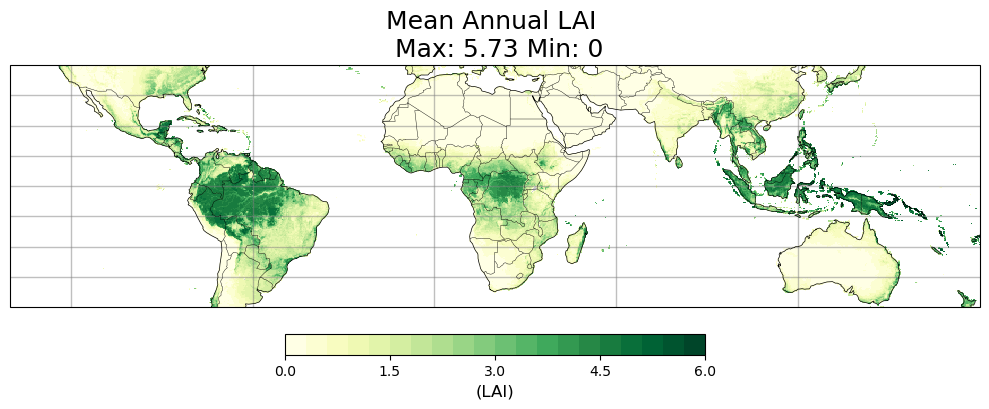

In [16]:
# Extract mean_lai_clim from the dataset
mean_lai_clim = ds['mean_lai_clim'].values  # shape (tile,)

# Flatten and build map array expected by plot_region: columns [value, lon, lat]
mean_lai_flat = np.squeeze(mean_lai_clim)
map_array = np.empty((n, 3), dtype=float)
map_array.fill(np.nan)
map_array[:, 0] = mean_lai_flat
map_array[:, 1] = lon_flat
map_array[:, 2] = lat_flat

# Calculate max and min values for the plot
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

print(f"mean_lai_clim max {maxval:.3g} min {minval:.3g}")

# Plot the map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=False,
    plot_title=f"Mean Annual LAI \n Max: {maxval:.3g} Min: {minval:.3g}",
    units='LAI',
    cmin=0,
    cmax=6,
    cmap="YlGn"
)
fig.tight_layout()
plt.show()

<xarray.Dataset> Size: 7MB
Dimensions:               (tile: 70773)
Dimensions without coordinates: tile
Data variables: (12/26)
    GRN_mean              (tile) float32 283kB ...
    GRN_std               (tile) float32 283kB ...
    LAI_mean              (tile) float32 283kB ...
    LAI_std               (tile) float32 283kB ...
    GWETPROF_mean         (tile) float32 283kB ...
    GWETPROF_std          (tile) float32 283kB ...
    ...                    ...
    SHLAND_mean           (tile) float32 283kB ...
    SHLAND_std            (tile) float32 283kB ...
    LHLAND_mean           (tile) float32 283kB ...
    LHLAND_std            (tile) float32 283kB ...
    EVLAND_mean           (tile) float32 283kB ...
    EVLAND_std            (tile) float32 283kB ...
Attributes:
    CreatedBy:  
    Date:       2025-07-01 at 21:05:21
Data variables in dataset: ['GRN_mean', 'GRN_std', 'LAI_mean', 'LAI_std', 'GWETPROF_mean', 'GWETPROF_std', 'GWETROOT_mean', 'GWETROOT_std', 'GWETTOP_mean', 'GWET

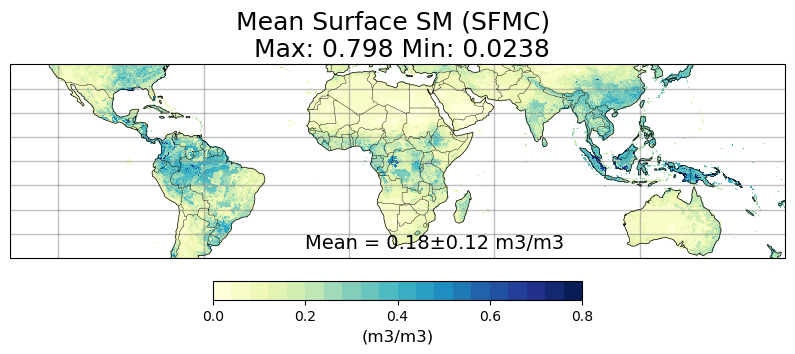

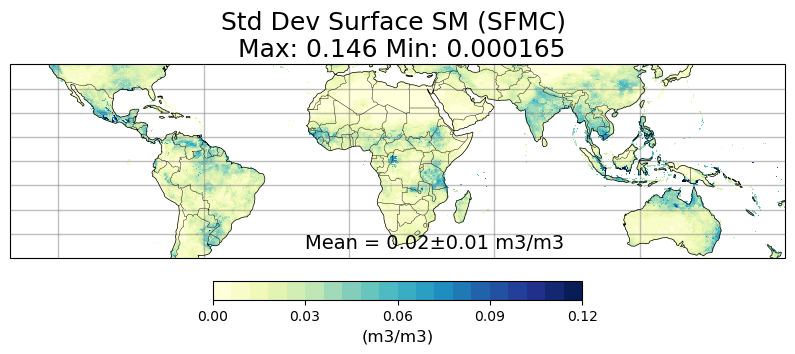

In [17]:
fn = "/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/OLv8_M36_cd/OLv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg/expt_means_20180801_20240630.nc4"

# open dataset and inspect
ds = xr.open_dataset(fn, decode_times=True)
print(ds)                 # quick view of variables / coords
print("Data variables in dataset:", list(ds.data_vars))



map_array[:,0] = ds['SFMC_mean'].values

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f"Mean Surface SM (SFMC) \n Max: {maxval:.3g} Min: {minval:.3g}",
    units='m3/m3',
    cmin=0,
    cmax=0.8,
    cmap="YlGnBu"
)

# and std dev
map_array[:,0] = ds['SFMC_std'].values
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f"Std Dev Surface SM (SFMC) \n Max: {maxval:.3g} Min: {minval:.3g}",
    units='m3/m3',
    cmin=0,
    cmax=0.12,
    cmap="YlGnBu"
)


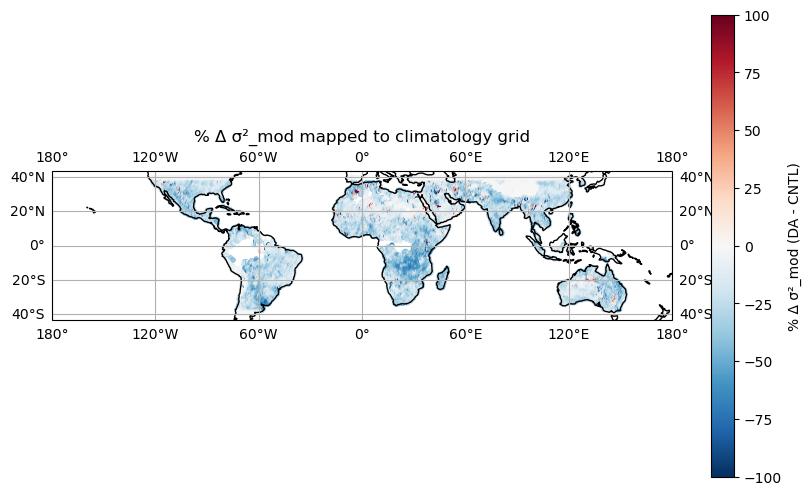

In [18]:
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial import cKDTree
import cartopy.crs as ccrs

# # Ensure coordinate vectors exist for KDTree inputs
# if "lons_vec" not in globals():
#     if "lons" in globals():
#         lons_vec = np.ravel(lons)
#         lats_vec = np.ravel(lats)
#     else:
#         lons_vec = np.ravel(lon_flat)
#         lats_vec = np.ravel(lat_flat)

lons_vec = np.ravel(lons_tc)
lats_vec = np.ravel(lats_tc)        

# inputs expected in notebook namespace: lons_vec, lats_vec, lon_flat, lat_flat, pct_sig2_vec, sigma2_CYG
# build points
vec_pts = np.column_stack((np.ravel(lons_vec), np.ravel(lats_vec)))
flat_pts = np.column_stack((np.ravel(lon_flat), np.ravel(lat_flat)))

# build KDTree and query
kdtree = cKDTree(vec_pts)
_, idxs = kdtree.query(flat_pts, k=1)

# map the vector field pct_sig2_vec to the flattened grid order
pct_sig2_flat_to_map = pct_sig2_vec[idxs]

# reshape to grid like lon_flat (if lon_flat is 1D, keep 1D)
try:
    grid_shape = lon_flat.shape
except NameError:
    grid_shape = pct_sig2_flat_to_map.shape
pct_map = pct_sig2_flat_to_map.reshape(grid_shape)

# Plot as scatter (lon/lat are 1D tile coords)
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
sc = ax.scatter(lon_flat, lat_flat, c=pct_map, cmap='RdBu_r', vmin=-100, vmax=100, s=12,
                edgecolor='none', transform=ccrs.PlateCarree())
ax.coastlines(); ax.gridlines(draw_labels=True)
plt.colorbar(sc, ax=ax, label='% Δ σ²_mod (DA - CNTL)')
plt.title('% Δ σ²_mod mapped to climatology grid')
plt.show()


In [19]:

target_dR2 = np.ravel(dR2_mod_vec)[idxs]
target_dR2_name = "Δ R²_mod (DA - CNTL)"
# Clip extreme outliers, keep between 1 and 99 percentiles
p_low, p_high = np.nanpercentile(target_dR2, [1, 99])
target_dR2 = np.where((target_dR2 < p_low) | (target_dR2 > p_high), np.nan, target_dR2)
print(f"target_dR2 clipped to 1-99% range: {p_low:.3g} to {p_high:.3g}")

target_pct_sig2 = np.ravel(pct_sig2_vec)[idxs]
target_pct_sig2_name = "% Δ σ²_mod (DA vs CNTL)"
# Clip extreme outliers, keep between 1 and 99 percentiles
p_low, p_high = np.nanpercentile(target_pct_sig2, [1, 99])
target_pct_sig2 = np.where((target_pct_sig2 < p_low) | (target_pct_sig2 > p_high), np.nan, target_pct_sig2)
print(f"target_pct_sig2 clipped to 1-99% range: {p_low:.3g} to {p_high:.3g}")

pred_sigma2_CYG = np.ravel(sigma2_CYG)[idxs]
p_low, p_high = np.nanpercentile(pred_sigma2_CYG, [1, 99])
pred_sigma2_CYG = np.where((pred_sigma2_CYG < p_low) | (pred_sigma2_CYG > p_high), np.nan, pred_sigma2_CYG)
pred_sigma2_CYG_name = "CYG L3 Obs Err Variance"

pred_ai = np.ravel(ai_flat)
p_low, p_high = np.nanpercentile(pred_ai, [1, 99])
pred_ai = np.where((pred_ai < p_low) | (pred_ai > p_high), np.nan, pred_ai)
pred_ai_name = "Aridity Index (P/PET)"

pred_mean_lai = np.ravel(mean_lai_flat)
p_low, p_high = np.nanpercentile(pred_mean_lai, [1, 99])
pred_mean_lai = np.where((pred_mean_lai < p_low) | (pred_mean_lai > p_high), np.nan, pred_mean_lai)
pred_mean_lai_name = "Mean Annual LAI (m2/m2)"

pred_mean_sm = np.ravel(ds['SFMC_mean'].values)
p_low, p_high = np.nanpercentile(pred_mean_sm, [1, 99])
pred_mean_sm = np.where((pred_mean_sm < p_low) | (pred_mean_sm > p_high), np.nan, pred_mean_sm)
pred_mean_sm_name = "Mean Surface SM (SFMC)"

pred_std_sm = np.ravel(ds['SFMC_std'].values)
p_low, p_high = np.nanpercentile(pred_std_sm, [1, 99])
pred_std_sm = np.where((pred_std_sm < p_low) | (pred_std_sm > p_high), np.nan, pred_std_sm)
pred_std_sm_name = "Std Dev Surface SM (SFMC)"

pred_sigma2_mod0 = np.ravel(S0['sigma2_mod'])[idxs]
p_low, p_high = np.nanpercentile(pred_sigma2_mod0, [1, 99])
pred_sigma2_mod0 = np.where((pred_sigma2_mod0 < p_low) | (pred_sigma2_mod0 > p_high), np.nan, pred_sigma2_mod0)
pred_sigma2_mod0_name = "CNTL Model Error Variance"


target_dR2 clipped to 1-99% range: -0.0668 to 0.253
target_pct_sig2 clipped to 1-99% range: -69.9 to 19.3


In [20]:
#import numpy as np
#import pandas as pd
#import sys
#from pathlib import Path

#from read_GEOSldas import read_tilecoord

# Load tile coordinates to get tile_id, com_lon, com_lat
ftc = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_cd.ldas_tilecoord.bin'

tc = read_tilecoord(ftc)
tile_id = np.array(tc['tile_id'], dtype=int)
lon_flat = tc['com_lon']
lat_flat = tc['com_lat']
com_lon = tc['com_lon']
com_lat = tc['com_lat']
n_tiles = len(tile_id)


mosaic_path = "/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/mosaic_veg_typs_fracs"

# --- thresholds & codes ---
PRIMARY_THRESH = 49.0
BARE_MAX = 10.0          # total < 0.10  -> bare
SPARSE_MAX = 20.0        # 0.10 <= total <= 0.20 -> sparse
MIXED_MIN = 20.0         # total > 0.20 and primary <= 0.50 -> mixed

BARE_CODE   = 0
MIXED_CODE  = 7
SPARSE_CODE = 8

# --- read whitespace-delimited text file ---
cols = ["tile_index","pfaf_code","primary_veg_type","secondary_veg_type",
        "primary_veg_frac","secondary_veg_frac","canopy_height","ASCATz0"]

records = []
with open(mosaic_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) != 8:
            parts = parts[-8:]  # keep the last 8 fields if a leading counter exists
        ti, pf, pty, sty = map(int, parts[:4])
        pfra, sfra, canh, z0 = map(float, parts[4:])
        records.append((ti, pf, pty, sty, pfra, sfra, canh, z0))

df = pd.DataFrame(records, columns=cols).set_index("tile_index")

# --- align to tile_id order ---
sub = df.reindex(tile_id)

p_type = sub["primary_veg_type"].astype("float")
p_frac = sub["primary_veg_frac"]
s_frac = sub["secondary_veg_frac"]
tot_frac = p_frac + s_frac

veg_code = np.full(len(sub), np.nan)

# Rule A: bare if total < 0.10
mask_bare = tot_frac < BARE_MAX
veg_code[mask_bare] = BARE_CODE

# Rule B: sparse if 0.10 <= total <= 0.20
mask_sparse = (~mask_bare) & (tot_frac <= SPARSE_MAX)
veg_code[mask_sparse] = SPARSE_CODE

# Rule C: primary type if primary > 0.50 (and not bare/sparse)
mask_primary = np.isnan(veg_code) & (p_frac > PRIMARY_THRESH)
veg_code[mask_primary] = p_type[mask_primary]

# Rule D: mixed if total > 0.20 and primary <= 0.50 (and not already set)
mask_mixed = np.isnan(veg_code) & (tot_frac > MIXED_MIN) & (p_frac <= PRIMARY_THRESH)
veg_code[mask_mixed] = MIXED_CODE

# Fallback: any remaining (e.g., missing tiles) -> sparse (or choose another)
veg_code[np.isnan(veg_code)] = SPARSE_CODE

veg_type_out = veg_code.astype(int)
total_fraction = tot_frac.fillna(0.0).to_numpy()

# Outputs:
#  - veg_type_out: integer array aligned with tile_id (1–6 from file, plus 7=mixed, 8=sparse, 0=bare)
#  - total_fraction: float array aligned with tile_id (primary + secondary)

print(len(veg_type_out), veg_type_out)

print("minimum primary fraction:", np.nanmin(p_frac))
print("minimum primary + secondary fraction:", np.nanmin(total_fraction))


reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_cd.ldas_tilecoord.bin
done reading file
70773 [4 4 4 ... 4 1 4]
minimum primary fraction: 50.0
minimum primary + secondary fraction: 99.99


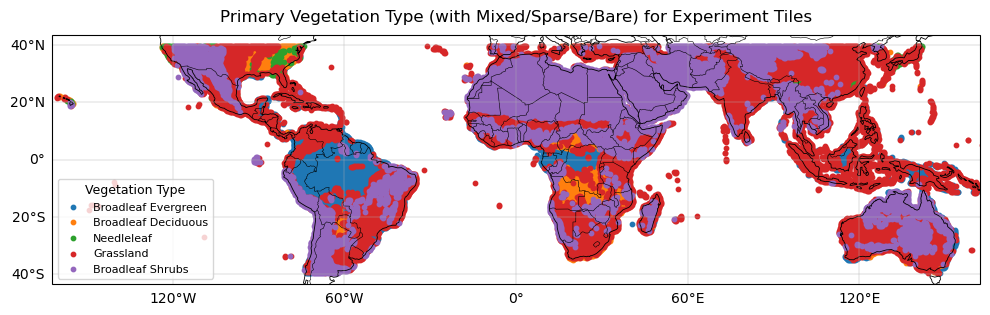

In [21]:
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

lat = np.asarray(com_lat)
lon = np.asarray(com_lon)

# bring longitudes to [-180, 180]
lon = np.where(lon > 180.0, lon - 360.0, lon)

# ---- labels for legend (codes from your mosaic definition + mixed/sparse/bare) ----
label_map = {
    0: "Bare",
    1: "Broadleaf Evergreen",
    2: "Broadleaf Deciduous",
    3: "Needleleaf",
    4: "Grassland",
    5: "Broadleaf Shrubs",
    6: "Dwarf Trees",
    7: "Mixed",
    8: "Sparse",
}

# only plot classes that appear
classes_present = np.unique(veg_type_out[np.isfinite(veg_type_out)])

# ---- figure ----
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=proj)

# set extent with small padding
lat_min, lat_max = np.nanmin(lat), np.nanmax(lat)
lon_min, lon_max = np.nanmin(lon), np.nanmax(lon)
dlat = max(2.0, 0.05 * (lat_max - lat_min + 1e-6))
dlon = max(2.0, 0.05 * (lon_max - lon_min + 1e-6))
ax.set_extent([lon_min - dlon, lon_max + dlon, lat_min - dlat, lat_max + dlat], crs=proj)

# map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3)
gl.top_labels = False
gl.right_labels = False

# plot each class as its own scatter (lets Matplotlib assign distinct default colors)
handles = []
labels = []
for code in classes_present:
    mask = veg_type_out == code
    if not np.any(mask):
        continue
    sc = ax.scatter(lon[mask], lat[mask], s=10, transform=proj, label=label_map.get(int(code), f"Class {int(code)}"))
    handles.append(sc)
    labels.append(label_map.get(int(code), f"Class {int(code)}"))

# legend
leg = ax.legend(handles, labels, title="Vegetation Type", loc="lower left", frameon=True, fontsize=8, title_fontsize=9)

ax.set_title("Primary Vegetation Type (with Mixed/Sparse/Bare) for Experiment Tiles", fontsize=12, pad=10)
plt.tight_layout()

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/297649396.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


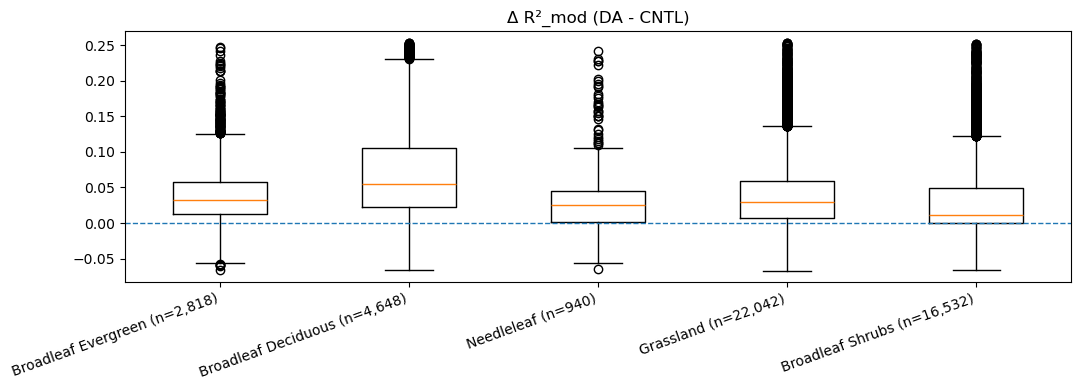

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/297649396.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


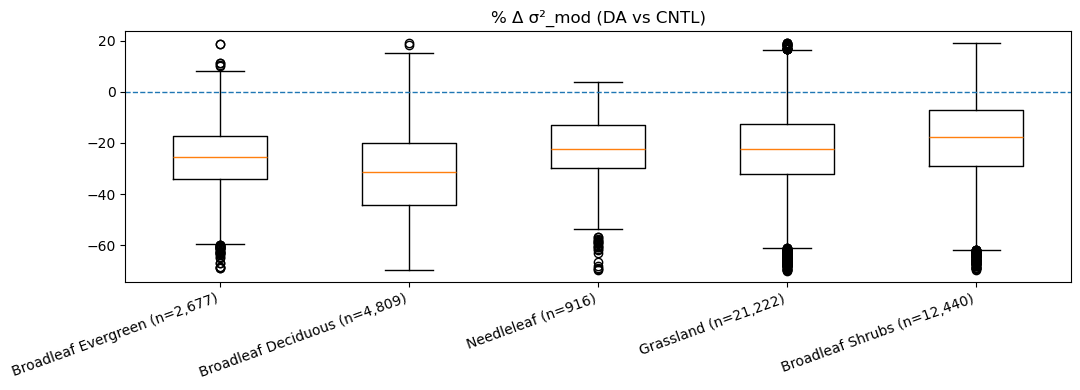

In [22]:
#import matplotlib.pyplot as plt

def box_by_veg(y, yname):
    label_map = {
        0: "Bare", 1: "Broadleaf Evergreen", 2: "Broadleaf Deciduous",
        3: "Needleleaf", 4: "Grassland", 5: "Broadleaf Shrubs",
        6: "Dwarf Trees", 7: "Mixed", 8: "Sparse",
    }
    order = [1,2,3,4,5,6,7,8,0]  # tweak if you like
    data, labels = [], []
    for k in order:
        sel = np.isfinite(veg_type_out) & (veg_type_out == k) & np.isfinite(y)
        if sel.any():
            data.append(y[sel])
            labels.append(f"{label_map[k]} (n={sel.sum():,})")
    plt.figure(figsize=(11,4))
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.axhline(0, ls="--", lw=1)
    plt.title(yname)
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

box_by_veg(target_dR2, target_dR2_name)
box_by_veg(target_pct_sig2, target_pct_sig2_name)


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3680986066.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = (df.groupby("bin")[t_name]
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3680986066.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=xlabels, showfliers=True)



=== Δ R²_mod (DA - CNTL) by Mean Annual LAI (m2/m2) fixed bins (5) ===
           count    median      mean       std       q25       q75
bin                                                               
0–0.10     10473  0.000386  0.019018  0.039752  0.000000  0.030285
0.10–0.50  10807  0.017741  0.027780  0.037934  0.000220  0.046903
0.50–1.30  11404  0.041039  0.050072  0.047181  0.016458  0.073468
1.30–2.60  10500  0.042242  0.054326  0.051234  0.018946  0.077935
>2.60       3724  0.029273  0.036655  0.044205  0.007265  0.056524


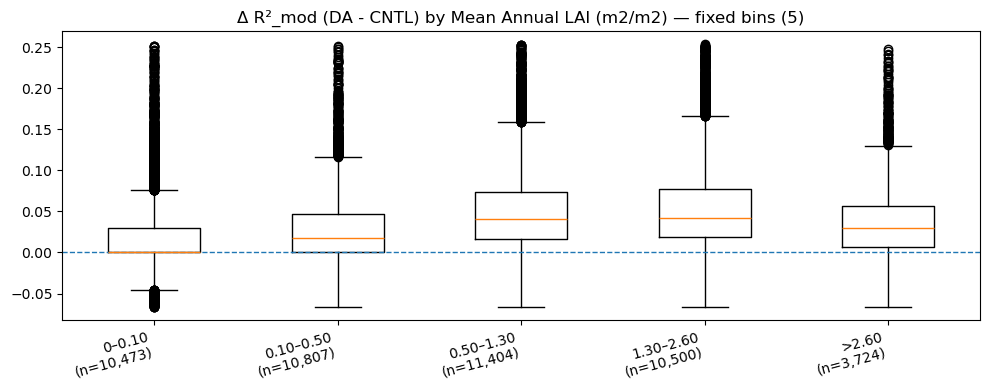


=== % Δ σ²_mod (DA vs CNTL) by Mean Annual LAI (m2/m2) fixed bins (5) ===
           count     median       mean        std        q25        q75
bin                                                                    
0–0.10      6664 -12.816806 -14.687395  13.524358 -22.772332  -4.326508
0.10–0.50   9860 -17.400815 -18.265215  14.827168 -28.109599  -5.940006
0.50–1.30  11397 -25.947676 -26.159586  14.773032 -35.489068 -16.599996
1.30–2.60  10571 -26.827975 -28.368434  14.685352 -37.692274 -17.753909
>2.60       3513 -23.874989 -24.892063  13.704481 -33.016360 -15.459397


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3680986066.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = (df.groupby("bin")[t_name]
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3680986066.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=xlabels, showfliers=True)


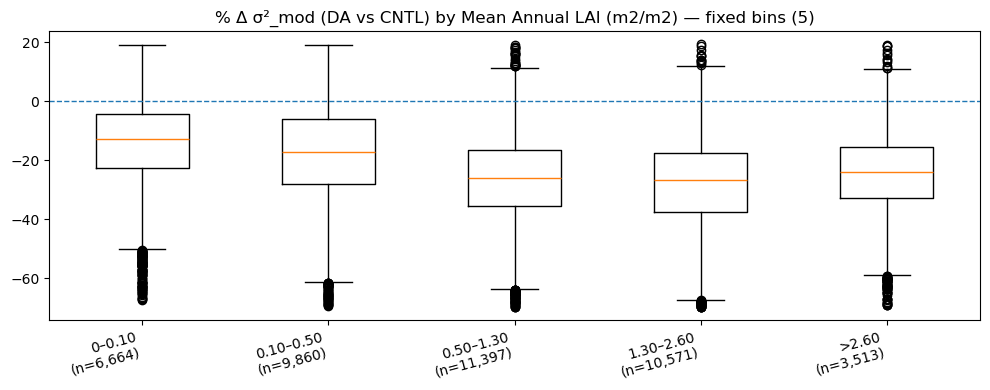

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3680986066.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = (df.groupby("bin")[t_name]



=== Δ R²_mod (DA - CNTL) by Aridity Index (P/PET) quantile bins (q=5) ===
                  count    median      mean       std       q25       q75
bin                                                                      
(0.00232, 0.116]  10722  0.004867  0.020192  0.039115  0.000000  0.031553
(0.116, 0.341]    11491  0.027807  0.036748  0.046158  0.000930  0.058774
(0.341, 0.694]    10518  0.044227  0.052991  0.051176  0.013969  0.079720
(0.694, 1.217]     9224  0.038480  0.048316  0.047212  0.014578  0.071724
(1.217, 2.727]     4518  0.025196  0.030106  0.032286  0.009387  0.043921


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3680986066.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=xlabels, showfliers=True)


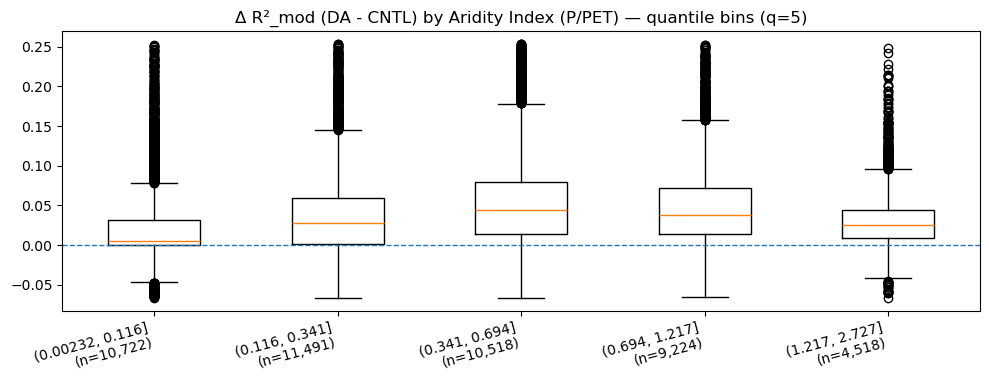


=== % Δ σ²_mod (DA vs CNTL) by Aridity Index (P/PET) quantile bins (q=5) ===
                  count     median       mean        std        q25        q75
bin                                                                           
(0.00232, 0.116]   7186 -13.440332 -15.091962  12.478277 -21.912960  -6.754190
(0.116, 0.341]    10648 -22.266443 -22.379501  15.715952 -32.484100 -10.582989
(0.341, 0.694]    10560 -27.068876 -27.467236  16.314638 -38.085623 -16.848875
(0.694, 1.217]     9134 -25.568865 -25.890209  14.484957 -35.506375 -15.944679
(1.217, 2.727]     4282 -20.201353 -20.910962  11.982749 -28.045810 -13.198326


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3680986066.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = (df.groupby("bin")[t_name]
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3680986066.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=xlabels, showfliers=True)


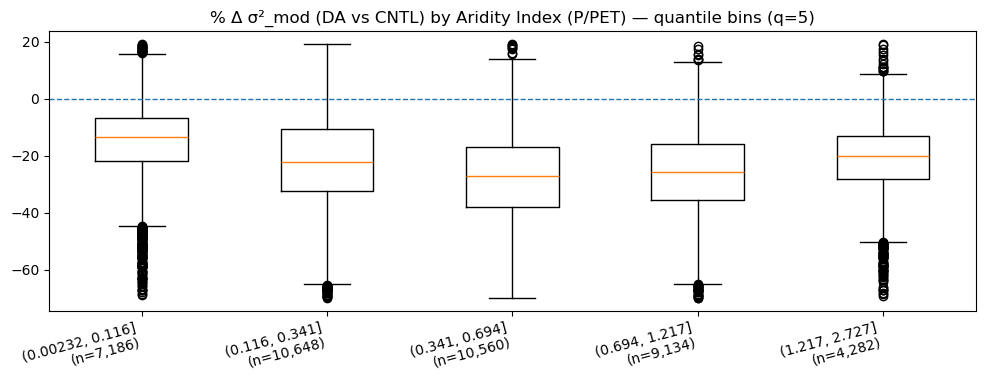

In [23]:
# Inputs assumed to exist:
#   pred_ai, pred_ai_name
#   pred_mean_lai, pred_mean_lai_name
#   pred_mean_greeness, pred_mean_greeness_name
#   target_dR2, target_dR2_name
#   target_pct_sig2, target_pct_sig2_name

def bin_and_plot(predictor, predictor_name, targets, q=5, dropna=True,
                 bins=None, labels=None, include_lowest=True, right=True):
    """
    Bin a predictor and plot target distributions per bin.

    If `bins` is provided (list-like), uses fixed bins via pd.cut.
    Otherwise, uses quantile bins via pd.qcut with q quantiles.

    targets = list of (target_array, target_name) tuples.
    """
    # assemble DataFrame
    df = pd.DataFrame({predictor_name: predictor})
    for t_arr, t_name in targets:
        df[t_name] = t_arr

    # clean NaNs/infs
    df = df.replace([np.inf, -np.inf], np.nan)
    if dropna:
        df = df.dropna(subset=[predictor_name])
    if df.empty:
        print(f"{predictor_name}: no valid rows after dropna.")
        return

    # choose binning method
    if bins is not None:
        # fixed bins
        df["bin"] = pd.cut(df[predictor_name], bins=bins, labels=labels,
                           include_lowest=include_lowest, right=right)
        bin_order = df["bin"].cat.categories
        bin_desc = f"fixed bins ({len(bin_order)})"
    else:
        # quantile bins; reduce q if duplicates happen
        q_use = q
        while True:
            try:
                df["bin"] = pd.qcut(df[predictor_name], q=q_use, duplicates="drop")
                break
            except ValueError:
                q_use -= 1
                if q_use < 2:
                    df["bin"] = pd.cut(df[predictor_name], bins=1)
                    break
        bin_order = df["bin"].cat.categories
        bin_desc = f"quantile bins (q={q_use})"

    # per-target plots and summaries
    for t_arr, t_name in targets:
        desc = (df.groupby("bin")[t_name]
                  .agg(count="count",
                       median=lambda x: np.nanmedian(x),
                       mean="mean",
                       std="std",
                       q25=lambda x: np.nanpercentile(x, 25),
                       q75=lambda x: np.nanpercentile(x, 75)))
        print(f"\n=== {t_name} by {predictor_name} {bin_desc} ===")
        print(desc)

        # prepare boxplot data & labels
        data, xlabels = [], []
        for b in bin_order:
            vals = df.loc[df["bin"] == b, t_name].dropna().values
            data.append(vals)
            xlabels.append(f"{b}\n(n={len(vals):,})")

        # plot
        plt.figure(figsize=(10, 4))
        plt.boxplot(data, labels=xlabels, showfliers=True)
        plt.axhline(0.0, ls="--", lw=1)
        plt.title(f"{t_name} by {predictor_name} — {bin_desc}")
        plt.xticks(rotation=15, ha="right")
        plt.tight_layout()
        plt.show()
     


targets_list = [
    (target_dR2, target_dR2_name),
    (target_pct_sig2, target_pct_sig2_name),
]

# 1) LAI with *fixed* bins (rounded, physically meaningful)
lai_bins   = [0.0, 0.10, 0.50, 1.30, 2.60, np.inf]
lai_labels = ["0–0.10", "0.10–0.50", "0.50–1.30", "1.30–2.60", ">2.60"]
bin_and_plot(pred_mean_lai, pred_mean_lai_name, targets_list,
             bins=lai_bins, labels=lai_labels)

# 3) Aridity Index with quantiles (unchanged) or supply your own thresholds
bin_and_plot(pred_ai, pred_ai_name, targets_list, q=5)
# e.g., fixed AI bins:
# ai_bins   = [0, 0.2, 0.5, 1.0, 2.0, np.inf]
# ai_labels = ["≤0.2","0.2–0.5","0.5–1.0","1.0–2.0",">2.0"]
# bin_and_plot(pred_ai, pred_ai_name, targets_list, bins=ai_bins, labels=ai_labels)

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/2463279877.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('RdBu_r', len(edges)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/2463279877.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0.08, 1, 1))


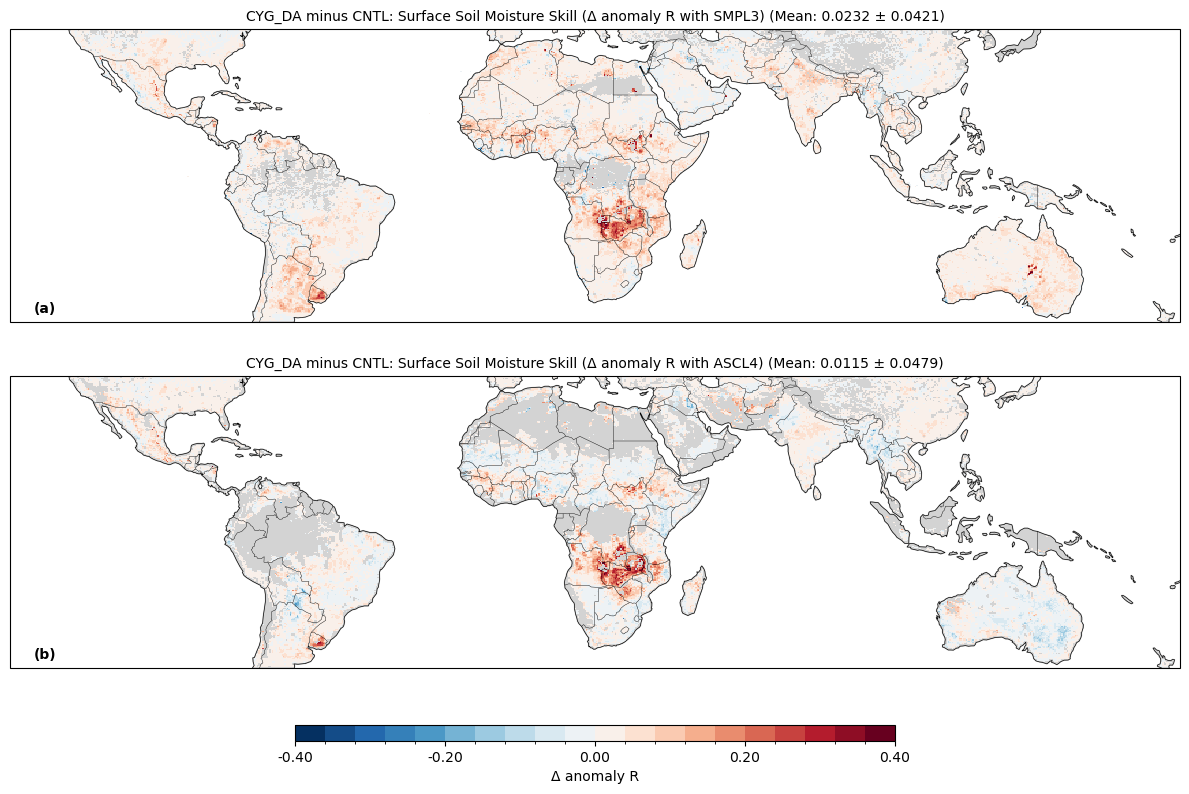

In [24]:
# Two-panel: Δ anomaly R (SMPL3 top, ASCL4 bottom) with discrete colorbars (pcolormesh)
paths = [
    (DATA_DIR / 'CYGNSS_Experiments/Evaluation/IVs/Rdiff_DAv8_M36_cd_minus_OLv8_M36_cd_SMPL3.mat', 'Δ anomaly R with SMPL3', '(a)'),
    (DATA_DIR / 'CYGNSS_Experiments/Evaluation/IVs/Rdiff_DAv8_M36_cd_minus_OLv8_M36_cd_ASCL4.mat', 'Δ anomaly R with ASCL4', '(b)')
]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vmin, vmax = -0.4, 0.4
edges = np.linspace(vmin, vmax, 21)
cmap = get_cmap('RdBu_r', len(edges)-1)
norm = BoundaryNorm(edges, cmap.N)
lats_ease, lons_ease = load_ease_grid(); lats_row, lons_col = lats_ease[:,1], lons_ease[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)
map_array = None
for ax, (path, label, lab) in zip(axes, paths):
    mat = sio.loadmat(path)
    rdiff = np.squeeze(mat['Rdiff_vector'])
    lons = np.squeeze(mat['lons'])
    lats = np.squeeze(mat['lats'])
    mean_val = np.nanmean(rdiff); std_val = np.nanstd(rdiff)
    if map_array is None:
        map_array = np.empty([len(lons), 3]); map_array.fill(np.nan)
        map_array[:,1] = lons; map_array[:,2] = lats
    map_array[:,0] = rdiff
    grid = build_ease_grid_mapping(map_array, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
    ax.set_title(f'CYG_DA minus CNTL: Surface Soil Moisture Skill ({label}) (Mean: {mean_val:.3g} ± {std_val:.3g})', fontsize=10)
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
    ax.tick_params(labelbottom=False, labelleft=False)

cax = fig.add_axes([0.25, 0.05, 0.50, 0.02])
cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')
cbar.set_label('Δ anomaly R', fontsize=10)
cbar.set_ticks(edges[::5])
cbar.ax.set_xticklabels([f"{t:.2f}" for t in edges[::5]])
cbar.ax.tick_params(labelsize=10)
fig.tight_layout(rect=(0, 0.08, 1, 1))
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3726897203.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(edges)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3726897203.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(edges)-1)


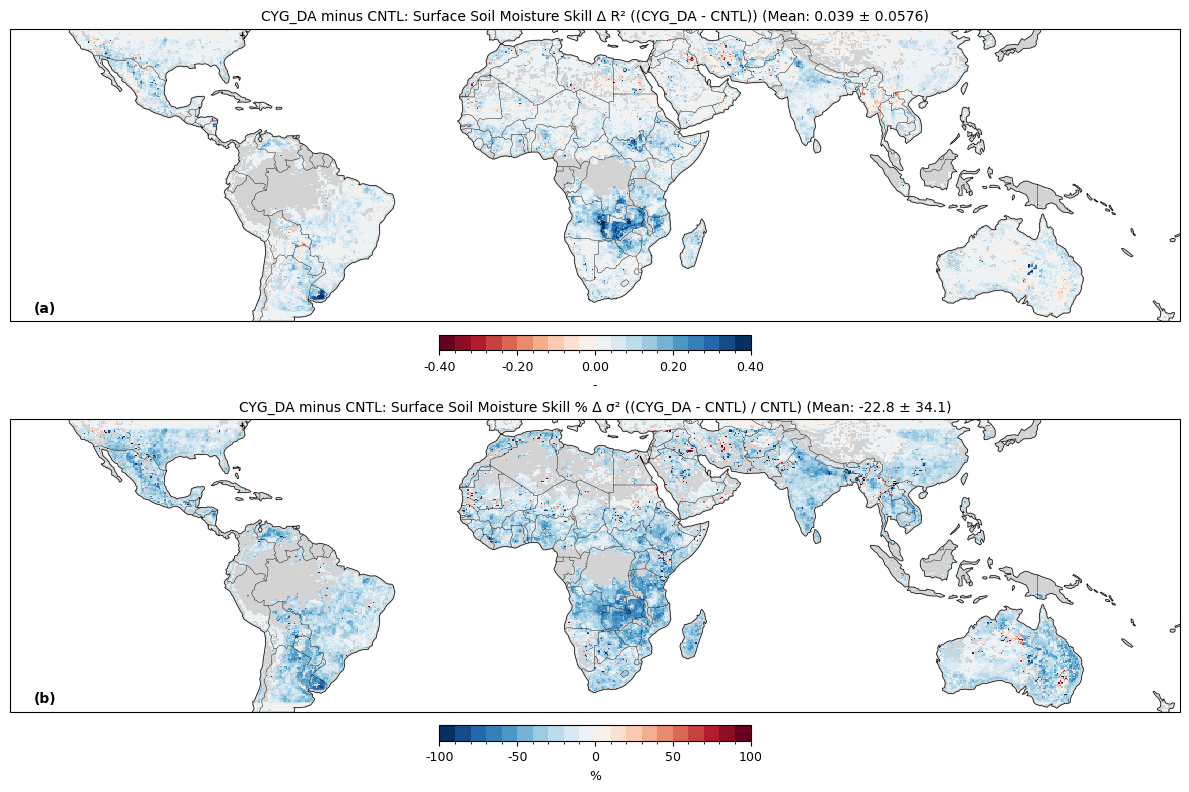

In [25]:
# Two-panel: Δ R²_mod (a) and % Δ σ²_mod (b) with discrete colorbars (pcolormesh)
vals = [
    (dR2_mod, 'CYG_DA minus CNTL: Surface Soil Moisture Skill Δ R² ((CYG_DA - CNTL))', 'RdBu', (-0.4, 0.4), '(a)', '-'),
    (pct_sig2, 'CYG_DA minus CNTL: Surface Soil Moisture Skill % Δ σ² ((CYG_DA - CNTL) / CNTL)', 'RdBu_r', (-100.0, 100.0), '(b)', '%')
]
lats_ease, lons_ease = load_ease_grid(); lats_row, lons_col = lats_ease[:,1], lons_ease[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)
map_array = np.empty([lons.size, 3]); map_array.fill(np.nan); map_array[:,1]=lons.flatten(); map_array[:,2]=lats.flatten()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, (data_grid, title, cmap_name, clim, lab, units) in zip(axes, vals):
    vmin, vmax = clim
    edges = np.linspace(vmin, vmax, 21)
    cmap = get_cmap(cmap_name, len(edges)-1)
    norm = BoundaryNorm(edges, cmap.N)
    data_flat = data_grid.flatten()
    mean_val = np.nanmean(data_flat); std_val = np.nanstd(data_flat)
    map_array[:,0] = data_flat
    grid = build_ease_grid_mapping(map_array, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
    ax.set_title(f"{title} (Mean: {mean_val:.3g} ± {std_val:.3g})", fontsize=10)
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
    ax.tick_params(labelbottom=False, labelleft=False)
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.04, fraction=0.046)
    cbar.set_label(units, fontsize=9)
    cbar.set_ticks(edges[::5])
    cbar.ax.set_xticklabels([f"{t:.0f}" if units == '%' else f"{t:.2f}" for t in edges[::5]])
    cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3407289038.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_lai = get_cmap('YlGn', len(edges_lai)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3407289038.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_ai = get_cmap('Spectral', len(a_edges)-1)


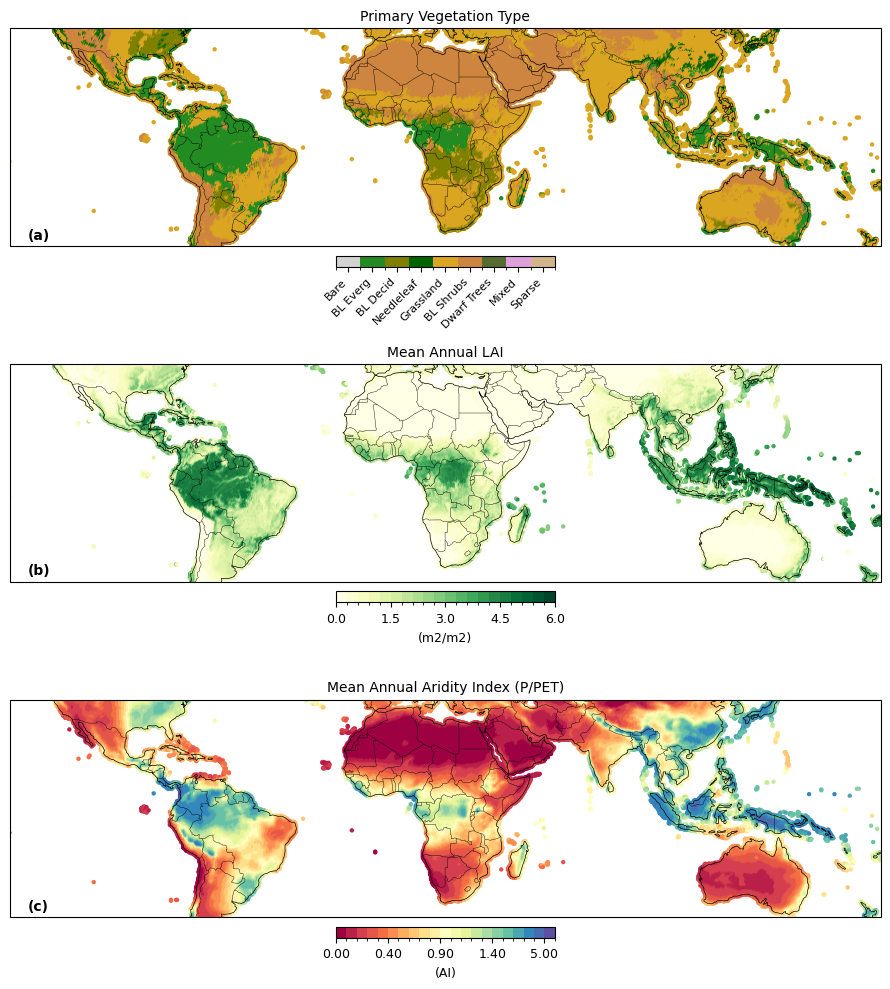

In [26]:
# 3x1: Vegetation type, Mean LAI, Aridity Index
label_map = {0:"Bare",1:"BL Everg",2:"BL Decid",3:"Needleleaf",4:"Grassland",5:"BL Shrubs",6:"Dwarf Trees",7:"Mixed",8:"Sparse"}
classes_present = np.unique(veg_type_out[np.isfinite(veg_type_out)])
veg_colors = ['lightgray','forestgreen','olive','darkgreen','goldenrod','peru','darkolivegreen','plum','tan']
veg_cmap = ListedColormap(veg_colors[:len(label_map)])
veg_bounds = np.arange(-0.5, 9.5, 1.0)

# Flatten AI/LAI grids
lon_flat_ai = np.squeeze(lon)
lat_flat_ai = np.squeeze(lat)
ai_flat = np.squeeze(ai)
mean_lai_flat = np.squeeze(mean_lai_clim)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Vegetation panel
a = axes[0]
lon_plot = np.where(com_lon > 180.0, com_lon - 360.0, com_lon)
sc0 = a.scatter(lon_plot, com_lat, c=veg_type_out, cmap=veg_cmap, norm=BoundaryNorm(veg_bounds, veg_cmap.N), s=10, edgecolor='none', transform=ccrs.PlateCarree())
a.add_feature(cfeature.COASTLINE, linewidth=0.5)
a.add_feature(cfeature.BORDERS, linewidth=0.3)
a.add_feature(cfeature.LAND, color='lightgray', zorder=0)
a.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
a.set_title('Primary Vegetation Type', fontsize=10)
a.text(0.02, 0.02, '(a)', transform=a.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
a.tick_params(labelbottom=False, labelleft=False)
cbar0 = fig.colorbar(sc0, ax=a, orientation='horizontal', pad=0.04, fraction=0.046, boundaries=veg_bounds)
# cbar0.set_label('Veg Type', fontsize=9)
cbar0.set_ticks(list(label_map.keys()))
cbar0.set_ticklabels([label_map[k] for k in label_map])
for label in cbar0.ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')
cbar0.ax.tick_params(labelsize=8)

# Mean LAI panel
ax1 = axes[1]
vmin_lai, vmax_lai = 0.0, 6.0
edges_lai = np.linspace(vmin_lai, vmax_lai, 21)
cmap_lai = get_cmap('YlGn', len(edges_lai)-1)
norm_lai = BoundaryNorm(edges_lai, cmap_lai.N)
# attempt reshape to 2D if possible, else keep 1D scatter
try:
    grid_shape = mean_lai_clim.shape
    if len(grid_shape)==2:
        lon_grid = lon_flat_ai.reshape(grid_shape)
        lat_grid = lat_flat_ai.reshape(grid_shape)
        data_grid = mean_lai_flat.reshape(grid_shape)
        sc1 = ax1.pcolormesh(lon_grid, lat_grid, data_grid, cmap=cmap_lai, norm=norm_lai, transform=ccrs.PlateCarree())
    else:
        sc1 = ax1.scatter(lon_flat_ai, lat_flat_ai, c=mean_lai_flat, cmap=cmap_lai, norm=norm_lai, s=10, edgecolor='none', transform=ccrs.PlateCarree())
except Exception:
    sc1 = ax1.scatter(lon_flat_ai, lat_flat_ai, c=mean_lai_flat, cmap=cmap_lai, norm=norm_lai, s=10, edgecolor='none', transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linewidth=0.3)
ax1.add_feature(cfeature.LAND, color='lightgray', zorder=0)
ax1.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
ax1.set_title('Mean Annual LAI', fontsize=10)
ax1.text(0.02, 0.02, '(b)', transform=ax1.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
ax1.tick_params(labelbottom=False, labelleft=False)
cbar1 = fig.colorbar(sc1, ax=ax1, orientation='horizontal', pad=0.04, fraction=0.046)
cbar1.set_label('(m2/m2)', fontsize=9)
cbar1.set_ticks(edges_lai[::5])
cbar1.ax.set_xticklabels([f"{t:.1f}" for t in edges_lai[::5]])
cbar1.ax.tick_params(labelsize=9)

# Aridity panel
ax2 = axes[2]
a_edges = np.array([0.00,0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00,1.10,1.20,1.30,1.40,1.50,1.75,2.00,3.00,5.00,10.00])
cmap_ai = get_cmap('Spectral', len(a_edges)-1)
norm_ai = BoundaryNorm(a_edges, cmap_ai.N)
try:
    grid_shape = ai.shape
    if len(grid_shape)==2:
        lon_grid = lon_flat_ai.reshape(grid_shape)
        lat_grid = lat_flat_ai.reshape(grid_shape)
        data_grid = ai_flat.reshape(grid_shape)
        sc2 = ax2.pcolormesh(lon_grid, lat_grid, data_grid, cmap=cmap_ai, norm=norm_ai, transform=ccrs.PlateCarree())
    else:
        sc2 = ax2.scatter(lon_flat_ai, lat_flat_ai, c=ai_flat, cmap=cmap_ai, norm=norm_ai, s=10, edgecolor='none', transform=ccrs.PlateCarree())
except Exception:
    sc2 = ax2.scatter(lon_flat_ai, lat_flat_ai, c=ai_flat, cmap=cmap_ai, norm=norm_ai, s=10, edgecolor='none', transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=0.3)
ax2.add_feature(cfeature.LAND, color='lightgray', zorder=0)
ax2.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
ax2.set_title('Mean Annual Aridity Index (P/PET)', fontsize=10)
ax2.text(0.02, 0.02, '(c)', transform=ax2.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
ax2.tick_params(labelbottom=False, labelleft=False)
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='horizontal', pad=0.04, fraction=0.046, boundaries=a_edges)
cbar2.set_label('(AI)', fontsize=9)
# set tick labels roughly every few bins
positions = a_edges[::5]
cbar2.set_ticks(positions)
cbar2.ax.set_xticklabels([f"{t:.2f}" for t in positions])
cbar2.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/2870144840.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/2870144840.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/2870144840.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_list, labels=labels, showf

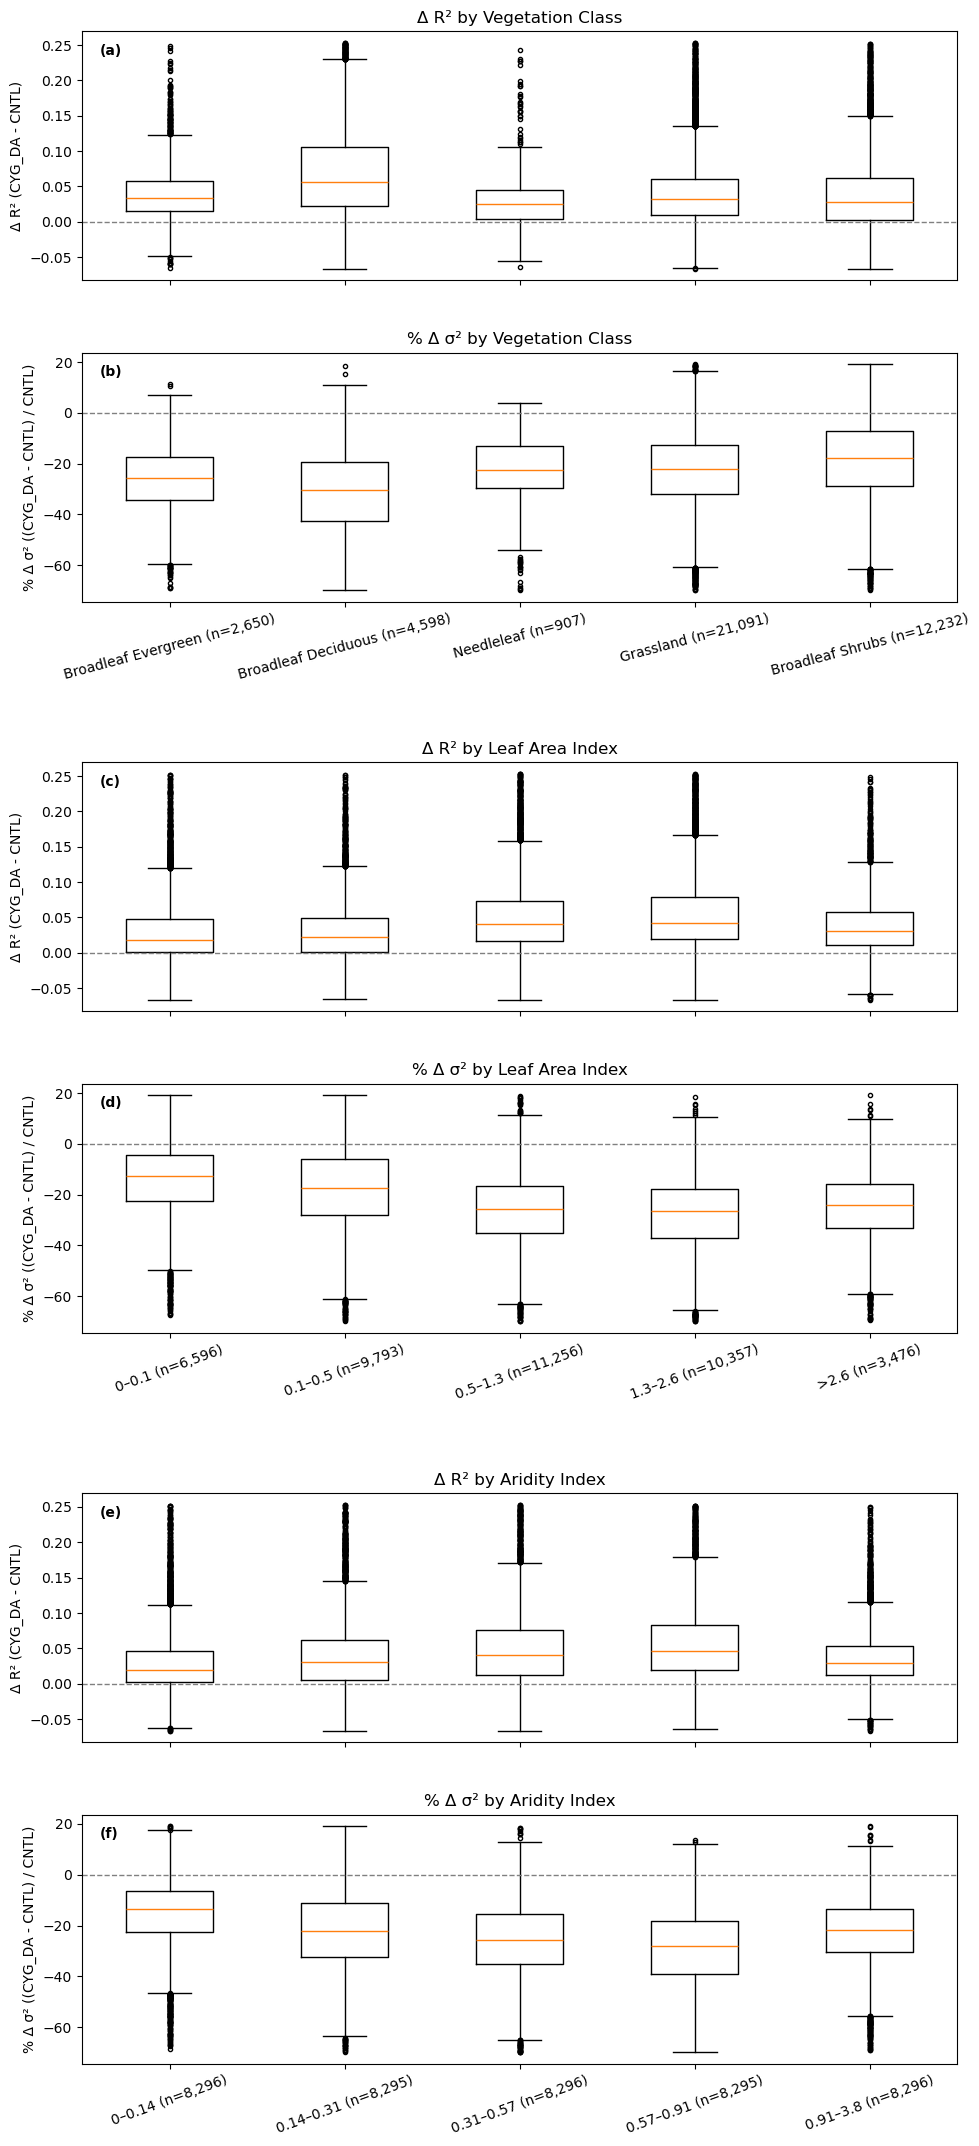

In [27]:
# Combined 6x1 boxplots with cross-masked targets (same n for ΔR² and %Δσ²)
import pandas as pd

veg_labels = {0: "Bare", 1: "Broadleaf Evergreen", 2: "Broadleaf Deciduous", 3: "Needleleaf", 4: "Grassland", 5: "Broadleaf Shrubs", 6: "Dwarf Trees", 7: "Mixed", 8: "Sparse"}
veg_order = [1,2,3,4,5,6,7,8,0]

veg_vec = veg_type_out.flatten()
tr_dR2 = target_dR2
tr_pct = target_pct_sig2
lai_vals = np.clip(mean_lai_flat, 0, None)
ai_vals = np.clip(ai_flat, 0, None)

# align lengths and build common mask
min_len = min(len(veg_vec), len(tr_dR2), len(tr_pct), len(lai_vals), len(ai_vals))
veg_vec = veg_vec[:min_len]; tr_dR2 = tr_dR2[:min_len]; tr_pct = tr_pct[:min_len]; lai_vals = lai_vals[:min_len]; ai_vals = ai_vals[:min_len]
common_mask = np.isfinite(veg_vec) & np.isfinite(tr_dR2) & np.isfinite(tr_pct) & np.isfinite(lai_vals) & np.isfinite(ai_vals)
veg_vec = veg_vec[common_mask]; tr_dR2 = tr_dR2[common_mask]; tr_pct = tr_pct[common_mask]; lai_vals = lai_vals[common_mask]; ai_vals = ai_vals[common_mask]

fig, axes = plt.subplots(6, 1, figsize=(10, 22))

# Helper to make a boxplot for categorical predictor

def box_cat(ax, cats, data, title, ylabel, labels_map=None, order=None):
    data_list=[]; labels=[]
    if order is None:
        order = np.unique(cats[np.isfinite(cats)])
    for k in order:
        sel = np.isfinite(cats) & (cats==k) & np.isfinite(data)
        if sel.any():
            data_list.append(data[sel])
            lab = labels_map.get(k, str(k)) if labels_map else str(k)
            labels.append(f"{lab} (n={sel.sum():,})")
    ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
    ax.axhline(0, ls='--', lw=1, color='gray')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)

# Veg panels
box_cat(axes[0], veg_vec, tr_dR2, 'Δ R² by Vegetation Class', 'Δ R² (CYG_DA - CNTL)', veg_labels, veg_order)
box_cat(axes[1], veg_vec, tr_pct, '% Δ σ² by Vegetation Class', '% Δ σ² ((CYG_DA - CNTL) / CNTL)', veg_labels, veg_order)

# LAI bins
lai_bins   = [0.0, 0.10, 0.50, 1.30, 2.60, np.inf]
lai_df = pd.DataFrame({'lai': lai_vals, 'dR2': tr_dR2, 'pct': tr_pct}).replace([np.inf,-np.inf], np.nan).dropna(subset=['lai'])
lai_df['bin'] = pd.cut(lai_df['lai'], bins=lai_bins, include_lowest=True)
for ax, col, title, ylabel in [(axes[2], 'dR2', 'Δ R² by Leaf Area Index', 'Δ R² (CYG_DA - CNTL)'), (axes[3], 'pct', '% Δ σ² by Leaf Area Index', '% Δ σ² ((CYG_DA - CNTL) / CNTL)')]:
    data_list=[]; labels=[]
    for lbl in lai_df['bin'].cat.categories:
        vals = lai_df.loc[lai_df['bin']==lbl, col].dropna().values
        left = max(0, lbl.left); right = lbl.right if lbl.right != float('inf') else np.inf
        lab = f'{left:.2g}–{right:.2g}' if right != np.inf else f'>{left:.2g}'
        data_list.append(vals)
        labels.append(f"{lab} (n={len(vals):,})")
    ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
    ax.axhline(0, ls='--', lw=1, color='gray')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)

# Aridity quantile bins (q=5)
ai_df = pd.DataFrame({'ai': ai_vals, 'dR2': tr_dR2, 'pct': tr_pct}).replace([np.inf,-np.inf], np.nan).dropna(subset=['ai'])
try:
    ai_df['bin'] = pd.qcut(ai_df['ai'], q=5, duplicates='drop')
except Exception:
    ai_df['bin'] = pd.cut(ai_df['ai'], bins=5)
for ax, col, title, ylabel in [(axes[4], 'dR2', 'Δ R² by Aridity Index', 'Δ R² (CYG_DA - CNTL)'), (axes[5], 'pct', '% Δ σ² by Aridity Index', '% Δ σ² ((CYG_DA - CNTL) / CNTL)')]:
    data_list=[]; labels=[]
    for lbl in ai_df['bin'].cat.categories:
        vals = ai_df.loc[ai_df['bin']==lbl, col].dropna().values
        left = max(0, lbl.left); right = lbl.right if lbl.right != float('inf') else np.inf
        lab = f'{left:.2g}–{right:.2g}' if right != np.inf else f'>{left:.2g}'
        data_list.append(vals)
        labels.append(f"{lab} (n={len(vals):,})")
    ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
    ax.axhline(0, ls='--', lw=1, color='gray')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)


# add panel labels
for ax, lab in zip(axes, ['(a)','(b)','(c)','(d)','(e)','(f)']):
    ax.text(0.02, 0.95, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')

# hide x ticklabels on R² panels
for idx in [0,2,4]:
    axes[idx].tick_params(labelbottom=False)

plt.tight_layout()
# bring (b) closer to (a), (d) closer to (c), (f) closer to (e)
pos_list = [ax.get_position() for ax in axes]
offsets = [0.0, 0.02, 0.0, 0.02, 0.0, 0.02]
for ax, pos, off in zip(axes, pos_list, offsets):
    ax.set_position([pos.x0, pos.y0 + off, pos.width, pos.height])

plt.show()


### CNTL-EXPT variants

In [28]:
# Compute inverted %Δσ² (CNTL-EXPT) so positive = better
pct_sig2_inv = -pct_sig2
pct_sig2_inv_vec = pct_sig2_inv.flatten()
pct_sig2_inv_masked = np.where(Mvalid, pct_sig2_inv, np.nan)
try:
    target_pct_sig2_inv = -target_pct_sig2
except Exception:
    target_pct_sig2_inv = None


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/42651160.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(edges)-1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/42651160.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(edges)-1)


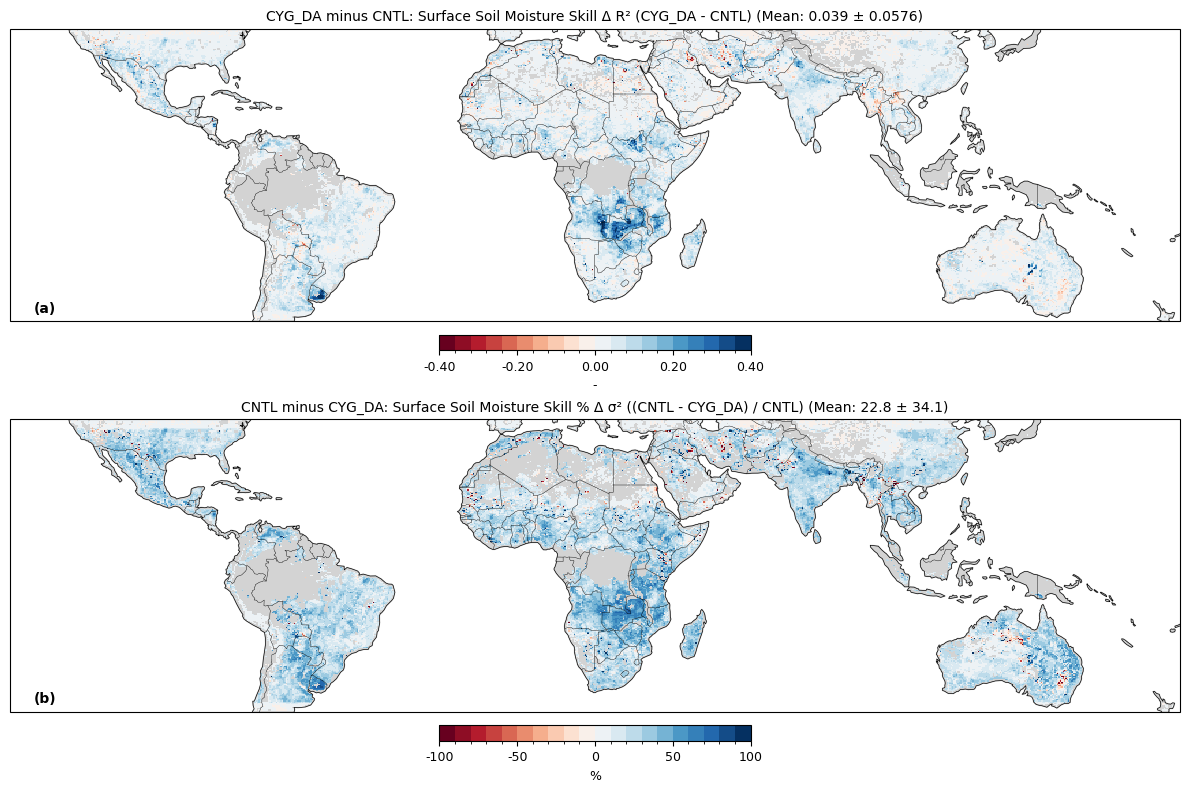

In [29]:
# Two-panel: Δ R²_mod and % Δ σ²_mod (CNTL-EXPT)
vals = [
    (dR2_mod, 'CYG_DA minus CNTL: Surface Soil Moisture Skill Δ R² (CYG_DA - CNTL)', 'RdBu', (-0.4, 0.4), '(a)', '-'),
    (pct_sig2_inv, 'CNTL minus CYG_DA: Surface Soil Moisture Skill % Δ σ² ((CNTL - CYG_DA) / CNTL)', 'RdBu', (-100.0, 100.0), '(b)', '%')
]
lats_ease, lons_ease = load_ease_grid(); lats_row, lons_col = lats_ease[:,1], lons_ease[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)
map_array_tmp = np.empty([lons.size, 3]); map_array_tmp.fill(np.nan); map_array_tmp[:,1]=lons.flatten(); map_array_tmp[:,2]=lats.flatten()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, (data_grid, title, cmap_name, clim, lab, units) in zip(axes, vals):
    vmin, vmax = clim
    edges = np.linspace(vmin, vmax, 21)
    cmap = get_cmap(cmap_name, len(edges)-1)
    norm = BoundaryNorm(edges, cmap.N)
    data_flat = data_grid.flatten()
    mean_val = np.nanmean(data_flat); std_val = np.nanstd(data_flat)
    map_array_tmp[:,0] = data_flat
    grid = build_ease_grid_mapping(map_array_tmp, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
    ax.set_title(f"{title} (Mean: {mean_val:.3g} ± {std_val:.3g})", fontsize=10)
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
    ax.tick_params(labelbottom=False, labelleft=False)
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.04, fraction=0.046)
    cbar.set_label(units, fontsize=9)
    cbar.set_ticks(edges[::5])
    cbar.ax.set_xticklabels([f"{t:.2f}" if units=='-' else f"{t:.0f}" for t in edges[::5]])
    cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3960548148.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3960548148.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/3960548148.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_list, labels=labels, showf

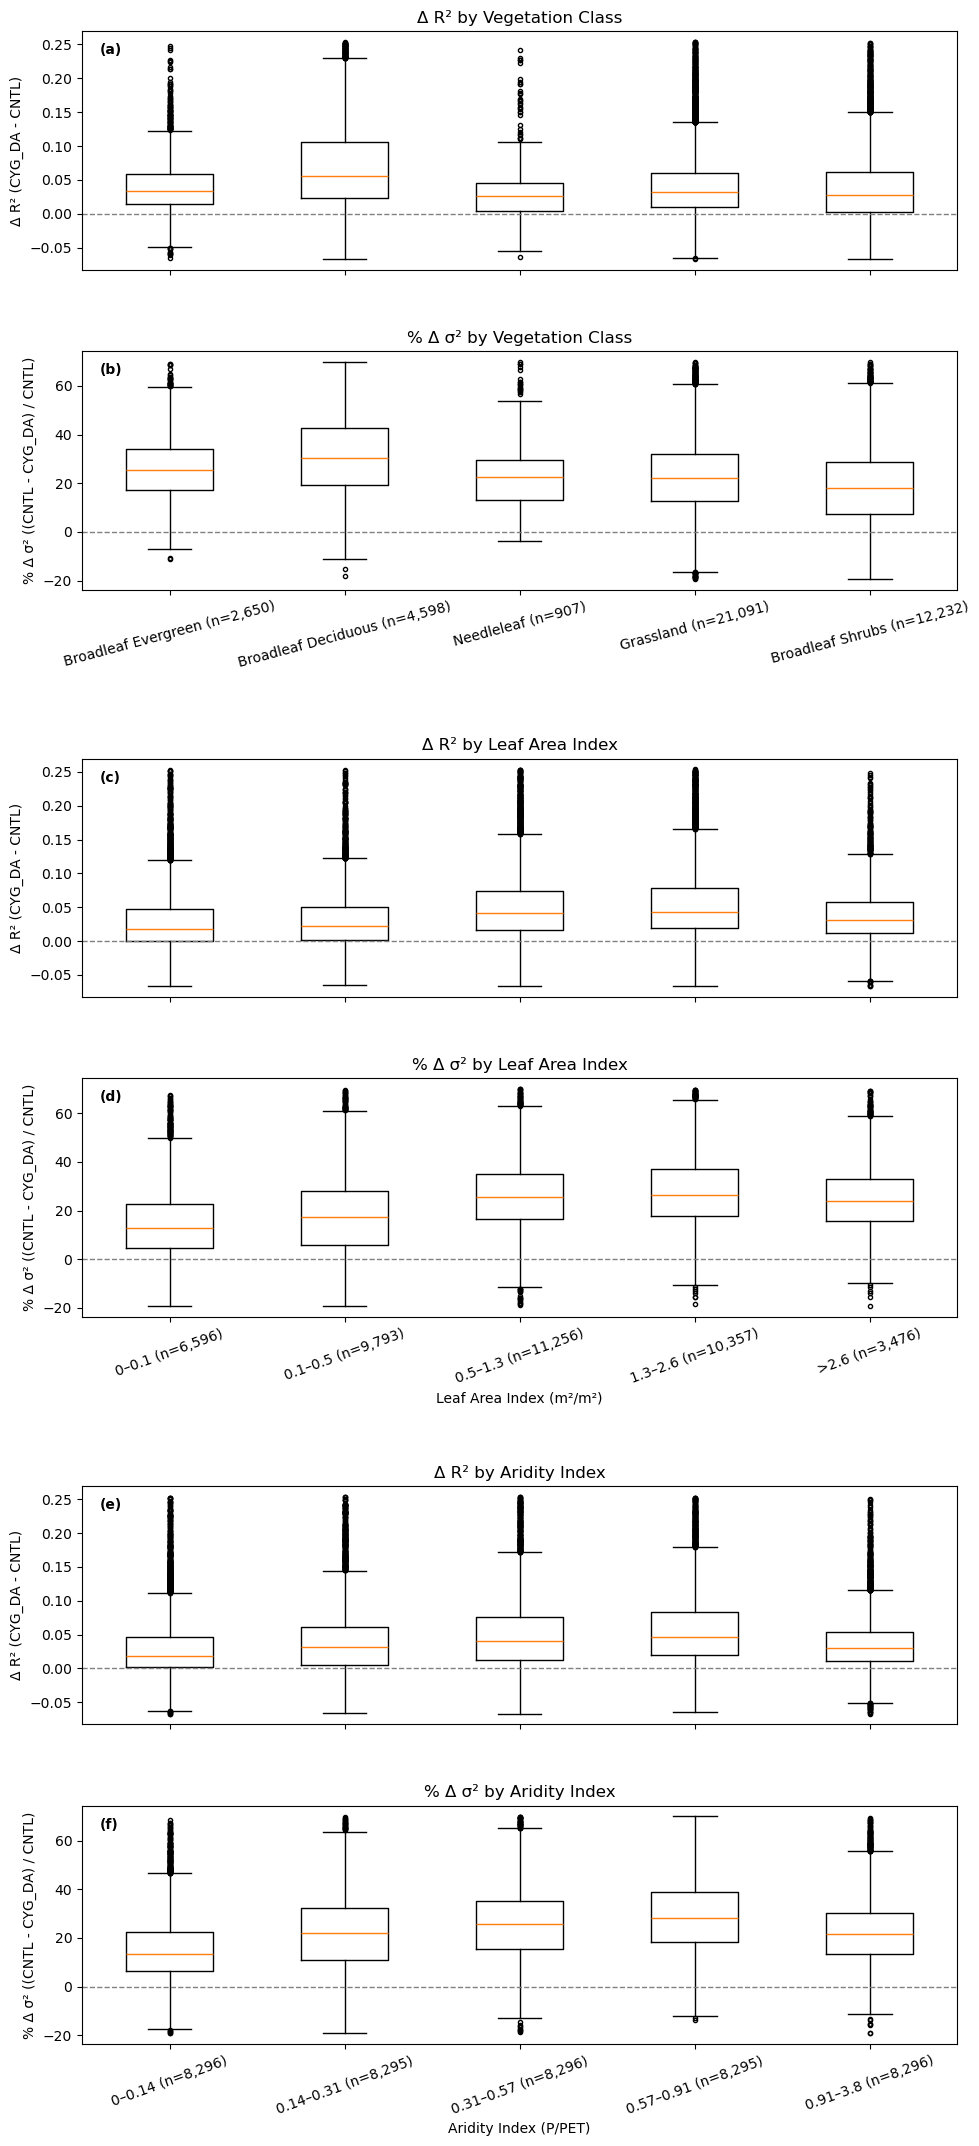

In [39]:
# Combined 6x1 boxplots (CNTL-EXPT %Δσ²)
import pandas as pd

veg_labels = {0: "Bare", 1: "Broadleaf Evergreen", 2: "Broadleaf Deciduous", 3: "Needleleaf", 4: "Grassland", 5: "Broadleaf Shrubs", 6: "Dwarf Trees", 7: "Mixed", 8: "Sparse"}
veg_order = [1,2,3,4,5,6,7,8,0]

veg_vec = veg_type_out.flatten()
tr_dR2 = target_dR2
try:
    tr_pct = target_pct_sig2_inv
except Exception:
    tr_pct = pct_sig2_inv_vec

lai_vals = np.clip(mean_lai_flat, 0, None)
ai_vals = np.clip(ai_flat, 0, None)

# align lengths and build common mask
min_len = min(len(veg_vec), len(tr_dR2), len(tr_pct), len(lai_vals), len(ai_vals))
veg_vec = veg_vec[:min_len]; tr_dR2 = tr_dR2[:min_len]; tr_pct = tr_pct[:min_len]; lai_vals = lai_vals[:min_len]; ai_vals = ai_vals[:min_len]
common_mask = np.isfinite(veg_vec) & np.isfinite(tr_dR2) & np.isfinite(tr_pct) & np.isfinite(lai_vals) & np.isfinite(ai_vals)
veg_vec = veg_vec[common_mask]; tr_dR2 = tr_dR2[common_mask]; tr_pct = tr_pct[common_mask]; lai_vals = lai_vals[common_mask]; ai_vals = ai_vals[common_mask]

fig, axes = plt.subplots(6, 1, figsize=(10, 22))

# Helper to make a boxplot for categorical predictor

def box_cat(ax, cats, data, title, ylabel, labels_map=None, order=None):
    data_list=[]; labels=[]
    if order is None:
        order = np.unique(cats[np.isfinite(cats)])
    for k in order:
        sel = np.isfinite(cats) & (cats==k) & np.isfinite(data)
        if sel.any():
            data_list.append(data[sel])
            lab = labels_map.get(k, str(k)) if labels_map else str(k)
            labels.append(f"{lab} (n={sel.sum():,})")
    ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
    ax.axhline(0, ls='--', lw=1, color='gray')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)

# Veg panels
box_cat(axes[0], veg_vec, tr_dR2, 'Δ R² by Vegetation Class', 'Δ R² (CYG_DA - CNTL)', veg_labels, veg_order)
box_cat(axes[1], veg_vec, tr_pct, '% Δ σ² by Vegetation Class', '% Δ σ² ((CNTL - CYG_DA) / CNTL)', veg_labels, veg_order)

# LAI bins
lai_bins   = [0.0, 0.10, 0.50, 1.30, 2.60, np.inf]
lai_df = pd.DataFrame({'lai': lai_vals, 'dR2': tr_dR2, 'pct': tr_pct}).replace([np.inf,-np.inf], np.nan).dropna(subset=['lai'])
lai_df['bin'] = pd.cut(lai_df['lai'], bins=lai_bins, include_lowest=True)
for ax, col, title, ylabel in [(axes[2], 'dR2', 'Δ R² by Leaf Area Index', 'Δ R² (CYG_DA - CNTL)'), (axes[3], 'pct', '% Δ σ² by Leaf Area Index', '% Δ σ² ((CNTL - CYG_DA) / CNTL)')]:
    data_list=[]; labels=[]
    for lbl in lai_df['bin'].cat.categories:
        vals = lai_df.loc[lai_df['bin']==lbl, col].dropna().values
        left = max(0, lbl.left); right = lbl.right if lbl.right != float('inf') else np.inf
        lab = f'{left:.2g}–{right:.2g}' if right != np.inf else f'>{left:.2g}'
        data_list.append(vals)
        labels.append(f"{lab} (n={len(vals):,})")
    ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
    ax.axhline(0, ls='--', lw=1, color='gray')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    if ax == axes[3]:
        ax.set_xlabel('Leaf Area Index (m²/m²)')
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)

# Aridity quantile bins (q=5)
ai_df = pd.DataFrame({'ai': ai_vals, 'dR2': tr_dR2, 'pct': tr_pct}).replace([np.inf,-np.inf], np.nan).dropna(subset=['ai'])
try:
    ai_df['bin'] = pd.qcut(ai_df['ai'], q=5, duplicates='drop')
except Exception:
    ai_df['bin'] = pd.cut(ai_df['ai'], bins=5)
for ax, col, title, ylabel in [(axes[4], 'dR2', 'Δ R² by Aridity Index', 'Δ R² (CYG_DA - CNTL)'), (axes[5], 'pct', '% Δ σ² by Aridity Index', '% Δ σ² ((CNTL - CYG_DA) / CNTL)')]:
    data_list=[]; labels=[]
    for lbl in ai_df['bin'].cat.categories:
        vals = ai_df.loc[ai_df['bin']==lbl, col].dropna().values
        left = max(0, lbl.left); right = lbl.right if lbl.right != float('inf') else np.inf
        lab = f'{left:.2g}–{right:.2g}' if right != np.inf else f'>{left:.2g}'
        data_list.append(vals)
        labels.append(f"{lab} (n={len(vals):,})")
    ax.boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker': 'o'})
    ax.axhline(0, ls='--', lw=1, color='gray')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    if ax == axes[5]:
        ax.set_xlabel('Aridity Index (P/PET)')
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)


# add panel labels
for ax, lab in zip(axes, ['(a)','(b)','(c)','(d)','(e)','(f)']):
    ax.text(0.02, 0.95, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')

# hide x ticklabels on R² panels
for idx in [0,2,4]:
    axes[idx].tick_params(labelbottom=False)

plt.tight_layout()
# bring (b) closer to (a), (d) closer to (c), (f) closer to (e)
pos_list = [ax.get_position() for ax in axes]
offsets = [0.0, 0.02, 0.0, 0.02, 0.0, 0.02]
for ax, pos, off in zip(axes, pos_list, offsets):
    ax.set_position([pos.x0, pos.y0 + off, pos.width, pos.height])

plt.show()

In [31]:
# Load Δ anomaly R with ASCL4 and map to TC grid
from scipy.spatial import cKDTree

ascl4_path = DATA_DIR / 'CYGNSS_Experiments/Evaluation/IVs/Rdiff_DAv8_M36_cd_minus_OLv8_M36_cd_ASCL4.mat'
mat_ascl4 = sio.loadmat(ascl4_path)
rdiff_ascl4 = np.squeeze(mat_ascl4['Rdiff_vector'])
lon_ascl4 = np.squeeze(mat_ascl4['lons'])
lat_ascl4 = np.squeeze(mat_ascl4['lats'])

src_pts = np.column_stack((lon_ascl4, lat_ascl4))
tgt_pts = np.column_stack((pred_lon_flat, pred_lat_flat))  # TC grid
kd = cKDTree(src_pts)
_, nn_idx = kd.query(tgt_pts, k=1)
rdiff_ascl4_tc = rdiff_ascl4[nn_idx]


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/49818482.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker':'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/49818482.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker':'o'})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/49818482.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot(data_list, labels=labels

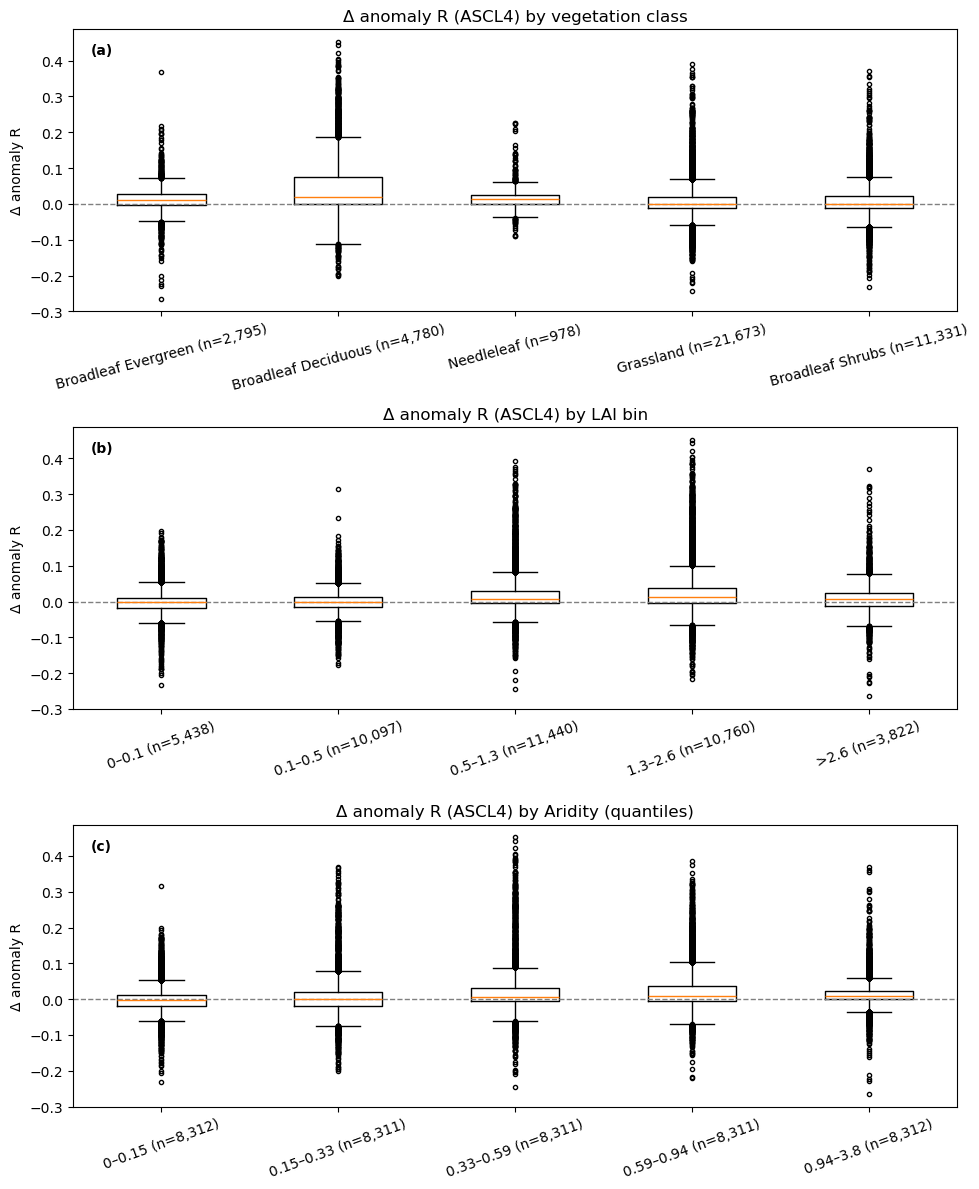

In [32]:
# 3x1 boxplots: Δ anomaly R with ASCL4 (mapped to TC grid)
import pandas as pd

veg_vec = veg_type_out.flatten()
target_rdiff = rdiff_ascl4_tc
lai_vals = np.clip(mean_lai_flat, 0, None)
ai_vals = np.clip(ai_flat, 0, None)

min_len = min(len(veg_vec), len(target_rdiff), len(lai_vals), len(ai_vals))
veg_vec = veg_vec[:min_len]
target_rdiff = target_rdiff[:min_len]
lai_vals = lai_vals[:min_len]
ai_vals = ai_vals[:min_len]

mask = np.isfinite(veg_vec) & np.isfinite(target_rdiff) & np.isfinite(lai_vals) & np.isfinite(ai_vals)
veg_vec = veg_vec[mask]
target_rdiff = target_rdiff[mask]
lai_vals = lai_vals[mask]
ai_vals = ai_vals[mask]

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Vegetation
veg_labels = {0: "Bare", 1: "Broadleaf Evergreen", 2: "Broadleaf Deciduous", 3: "Needleleaf", 4: "Grassland", 5: "Broadleaf Shrubs", 6: "Dwarf Trees", 7: "Mixed", 8: "Sparse"}
veg_order = [1,2,3,4,5,6,7,8,0]
data_list=[]; labels=[]
for k in veg_order:
    sel = (veg_vec==k)
    if sel.any():
        data_list.append(target_rdiff[sel])
        labels.append(f"{veg_labels[k]} (n={sel.sum():,})")
axes[0].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker':'o'})
axes[0].axhline(0, ls='--', lw=1, color='gray')
axes[0].set_title('Δ anomaly R (ASCL4) by vegetation class')
axes[0].set_ylabel('Δ anomaly R')
axes[0].tick_params(labelbottom=True)
axes[0].text(0.02, 0.95, '(a)', transform=axes[0].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
for t in axes[0].get_xticklabels():
    t.set_rotation(15)

# LAI bins
lai_bins   = [0.0, 0.10, 0.50, 1.30, 2.60, np.inf]
lai_df = pd.DataFrame({'lai': lai_vals, 'rdiff': target_rdiff}).replace([np.inf,-np.inf], np.nan).dropna(subset=['lai'])
lai_df['bin'] = pd.cut(lai_df['lai'], bins=lai_bins, include_lowest=True)
data_list=[]; labels=[]
for lbl in lai_df['bin'].cat.categories:
    vals = lai_df.loc[lai_df['bin']==lbl, 'rdiff'].dropna().values
    left = max(0, lbl.left); right = lbl.right if lbl.right != float('inf') else np.inf
    lab = f'{left:.2g}–{right:.2g}' if right != np.inf else f'>{left:.2g}'
    data_list.append(vals)
    labels.append(f"{lab} (n={len(vals):,})")
axes[1].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker':'o'})
axes[1].axhline(0, ls='--', lw=1, color='gray')
axes[1].set_title('Δ anomaly R (ASCL4) by LAI bin')
axes[1].set_ylabel('Δ anomaly R')
axes[1].tick_params(labelbottom=True)
axes[1].text(0.02, 0.95, '(b)', transform=axes[1].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
for t in axes[1].get_xticklabels():
    t.set_rotation(20)

# Aridity quantile bins
ai_df = pd.DataFrame({'ai': ai_vals, 'rdiff': target_rdiff}).replace([np.inf,-np.inf], np.nan).dropna(subset=['ai'])
try:
    ai_df['bin'] = pd.qcut(ai_df['ai'], q=5, duplicates='drop')
except Exception:
    ai_df['bin'] = pd.cut(ai_df['ai'], bins=5)
data_list=[]; labels=[]
for lbl in ai_df['bin'].cat.categories:
    vals = ai_df.loc[ai_df['bin']==lbl, 'rdiff'].dropna().values
    left = max(0, lbl.left); right = lbl.right if lbl.right != float('inf') else np.inf
    lab = f'{left:.2g}–{right:.2g}' if right != np.inf else f'>{left:.2g}'
    data_list.append(vals)
    labels.append(f"{lab} (n={len(vals):,})")
axes[2].boxplot(data_list, labels=labels, showfliers=True, flierprops={'markersize':3, 'marker':'o'})
axes[2].axhline(0, ls='--', lw=1, color='gray')
axes[2].set_title('Δ anomaly R (ASCL4) by Aridity (quantiles)')
axes[2].set_ylabel('Δ anomaly R')
axes[2].text(0.02, 0.95, '(c)', transform=axes[2].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
for t in axes[2].get_xticklabels():
    t.set_rotation(20)

plt.tight_layout()
plt.show()


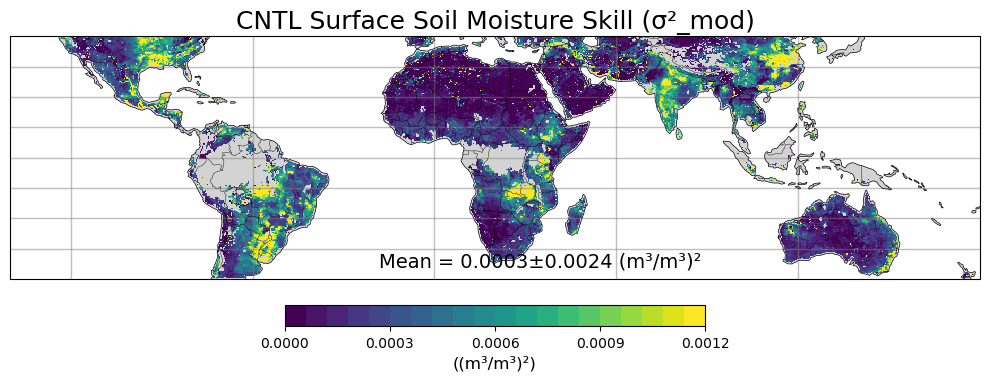

In [33]:
map_array = np.full((lons.size, 3), np.nan)
map_array[:, 1] = lons.flatten()
map_array[:, 2] = lats.flatten()

sig_cntl = S0["sigma2_mod"].flatten()
map_array[:, 0] = sig_cntl

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CNTL Surface Soil Moisture Skill (σ²_mod)',
    units='(m³/m³)²',
    cmin=0.00,
    cmax=0.0012
)
fig.tight_layout()

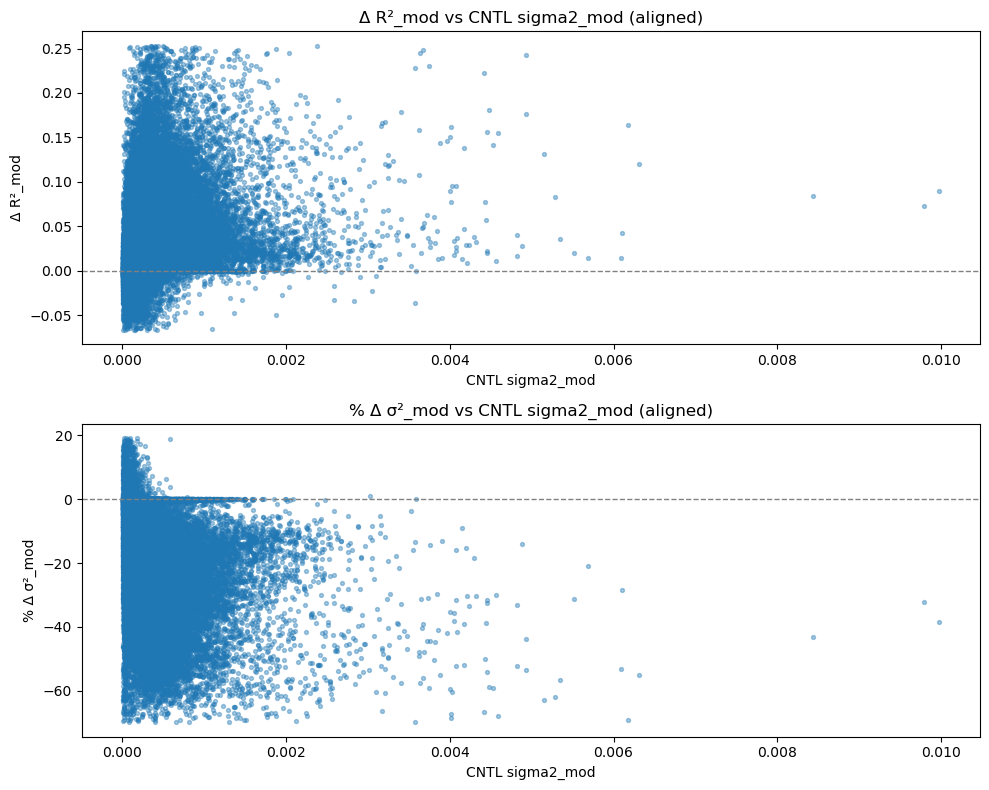

In [34]:
# Scatter: CNTL sigma2_mod aligned to target grid vs ΔR²_mod and %Δσ²_mod
sig20_flat = S0["sigma2_mod"].flatten()
tr_dR2_al = target_dR2
tr_pct_al = target_pct_sig2

# Use the existing KDTree mapping index to align to the same grid
sig20_al = sig20_flat[idxs]


mask = np.isfinite(sig20_al) & np.isfinite(tr_dR2_al) & np.isfinite(tr_pct_al)
sig20_al = sig20_al[mask]
tr_dR2_al = tr_dR2_al[mask]
tr_pct_al = tr_pct_al[mask]

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].scatter(sig20_al, tr_dR2_al, s=8, alpha=0.4)
axes[0].axhline(0, ls="--", lw=1, color="gray")
axes[0].set_xlabel("CNTL sigma2_mod")
axes[0].set_ylabel("Δ R²_mod")
axes[0].set_title("Δ R²_mod vs CNTL sigma2_mod (aligned)")

axes[1].scatter(sig20_al, tr_pct_al, s=8, alpha=0.4)
axes[1].axhline(0, ls="--", lw=1, color="gray")
axes[1].set_xlabel("CNTL sigma2_mod")
axes[1].set_ylabel("% Δ σ²_mod")
axes[1].set_title("% Δ σ²_mod vs CNTL sigma2_mod (aligned)")

plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/1625389985.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True, flierprops={"markersize": 3, "marker": "o"})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/1625389985.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True, flierprops={"markersize": 3, "marker": "o"})


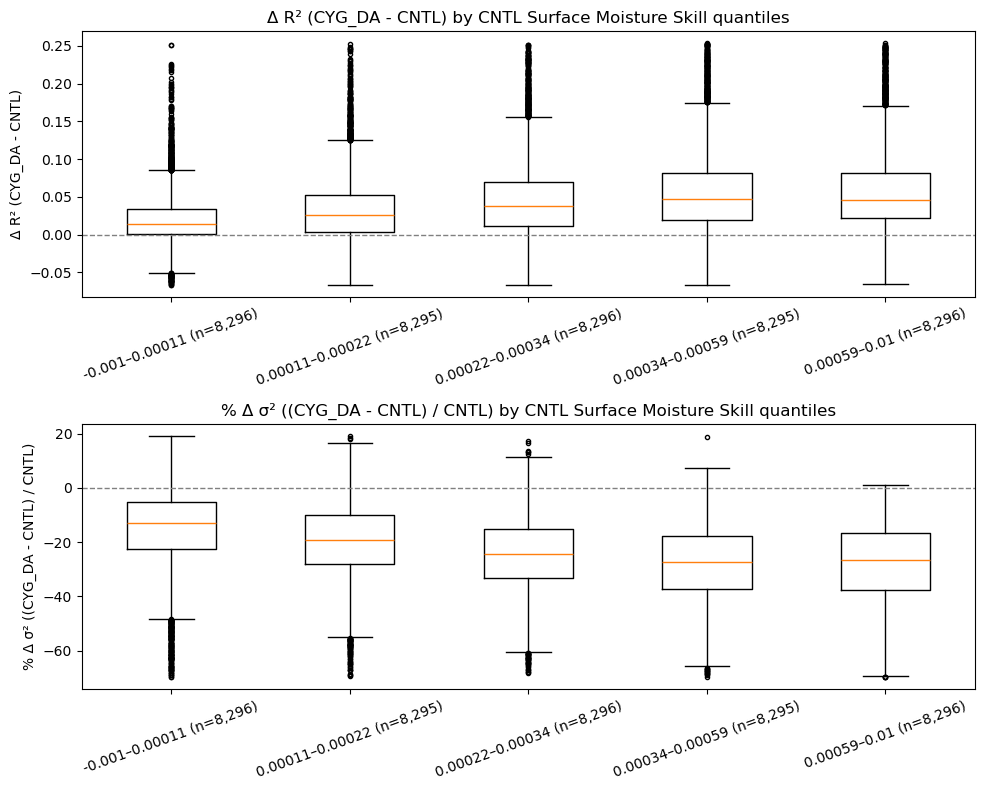

In [35]:
# Boxplots: ΔR²_mod and %Δσ²_mod by sigma2_mod quantiles
import pandas as pd

q = 5  # choose quantile count
df_sig = pd.DataFrame({
    "sig20": sig20_al,
    "dR2": tr_dR2_al,
    "pct": tr_pct_al,
}).replace([np.inf, -np.inf], np.nan).dropna()

try:
    df_sig["bin"] = pd.qcut(df_sig["sig20"], q=q, duplicates="drop")
except Exception:
    df_sig["bin"] = pd.cut(df_sig["sig20"], bins=q)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for ax, col, title in [
    (axes[0], "dR2", "Δ R² (CYG_DA - CNTL) by CNTL Surface Moisture Skill quantiles"),
    (axes[1], "pct", "% Δ σ² ((CYG_DA - CNTL) / CNTL) by CNTL Surface Moisture Skill quantiles"),
]:
    data, labels = [], []
    for lbl in df_sig["bin"].cat.categories:
        vals = df_sig.loc[df_sig["bin"] == lbl, col].values
        data.append(vals)
        labels.append(f"{lbl.left:.2g}–{lbl.right:.2g} (n={len(vals):,})")
    ax.boxplot(data, labels=labels, showfliers=True, flierprops={"markersize": 3, "marker": "o"})
    ax.axhline(0, ls="--", lw=1, color="gray")
    ax.set_title(title)
    ax.set_ylabel("Δ R² (CYG_DA - CNTL)" if col == "dR2" else "% Δ σ² ((CYG_DA - CNTL) / CNTL)")
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)

plt.tight_layout()
plt.show()

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/1816407024.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True, flierprops={"markersize": 3, "marker": "o"})
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/1816407024.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True, flierprops={"markersize": 3, "marker": "o"})


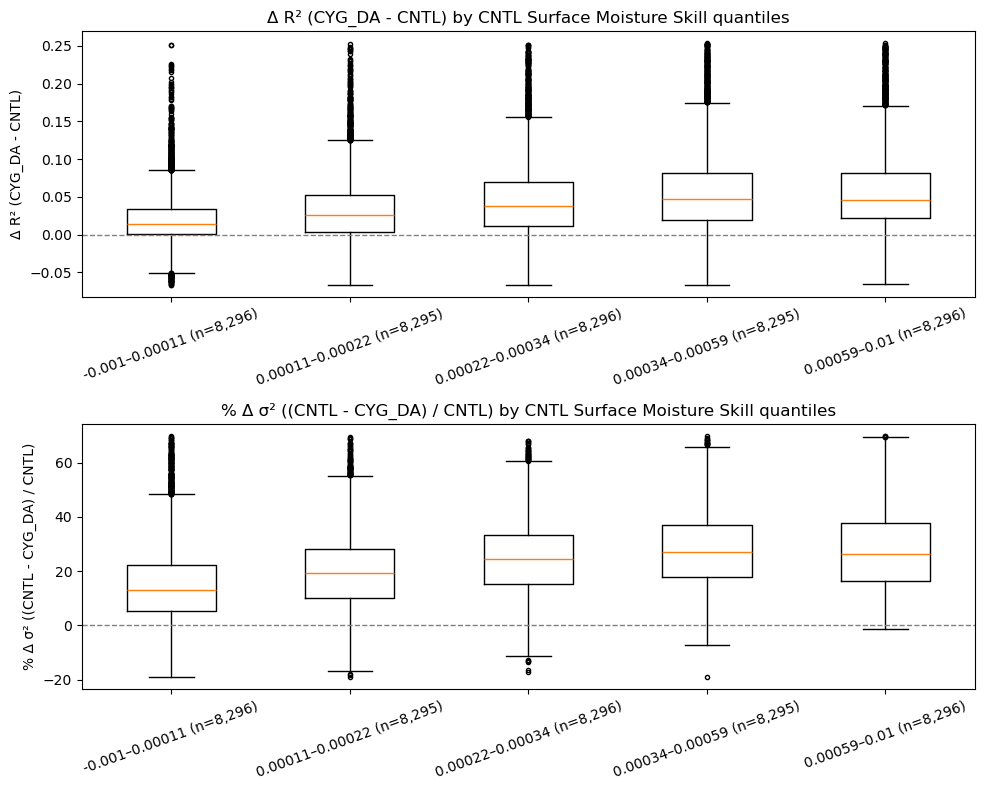

In [36]:
# Boxplots: ΔR²_mod and inverted %Δσ²_mod by sigma2_mod quantiles
import pandas as pd

tr_pct_inv_al = -tr_pct_al  # CNTL - CYG_DA normalized by CNTL

q = 5  # choose quantile count
df_sig_inv = pd.DataFrame({
    "sig20": sig20_al,
    "dR2": tr_dR2_al,
    "pct": tr_pct_inv_al,
}).replace([np.inf, -np.inf], np.nan).dropna()

try:
    df_sig_inv["bin"] = pd.qcut(df_sig_inv["sig20"], q=q, duplicates="drop")
except Exception:
    df_sig_inv["bin"] = pd.cut(df_sig_inv["sig20"], bins=q)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for ax, col, title in [
    (axes[0], "dR2", "Δ R² (CYG_DA - CNTL) by CNTL Surface Moisture Skill quantiles"),
    (axes[1], "pct", "% Δ σ² ((CNTL - CYG_DA) / CNTL) by CNTL Surface Moisture Skill quantiles"),
]:
    data, labels = [], []
    for lbl in df_sig_inv["bin"].cat.categories:
        vals = df_sig_inv.loc[df_sig_inv["bin"] == lbl, col].values
        data.append(vals)
        labels.append(f"{lbl.left:.2g}–{lbl.right:.2g} (n={len(vals):,})")
    ax.boxplot(data, labels=labels, showfliers=True, flierprops={"markersize": 3, "marker": "o"})
    ax.axhline(0, ls="--", lw=1, color="gray")
    ax.set_title(title)
    ax.set_ylabel("Δ R² (CYG_DA - CNTL)" if col == "dR2" else "% Δ σ² ((CNTL - CYG_DA) / CNTL)")
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)

plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/825242915.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(edges) - 1)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/825242915.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(edges) - 1)


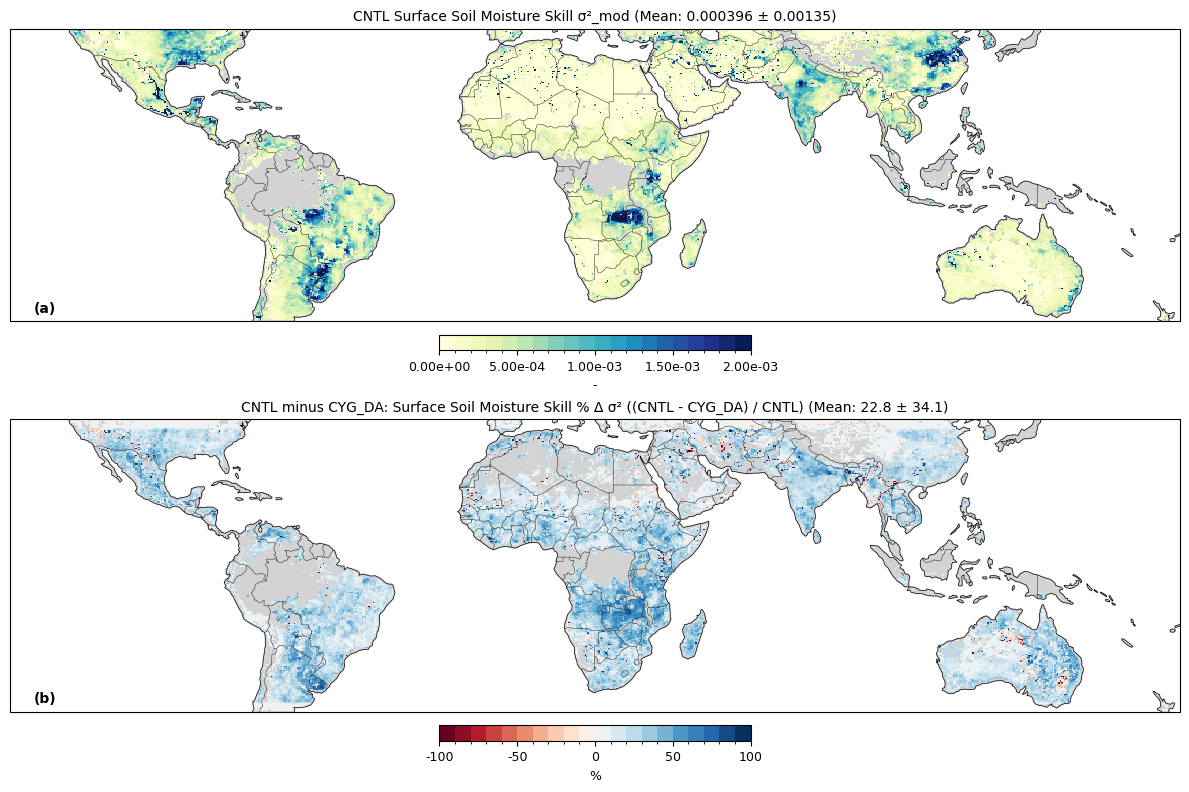

In [37]:
# Two-panel: CNTL sigma2_mod (a) and CNTL minus CYG_DA % Δ σ² (b)
vals = [
    (S0["sigma2_mod"], 'CNTL Surface Soil Moisture Skill σ²_mod', 'YlGnBu', (0.0, 2e-3), '(a)', '-'),
    (pct_sig2_inv, 'CNTL minus CYG_DA: Surface Soil Moisture Skill % Δ σ² ((CNTL - CYG_DA) / CNTL)', 'RdBu', (-100.0, 100.0), '(b)', '%'),
]

lats_ease, lons_ease = load_ease_grid(); lats_row, lons_col = lats_ease[:,1], lons_ease[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)
map_array_tmp = np.empty([lons.size, 3]); map_array_tmp.fill(np.nan); map_array_tmp[:,1] = lons.flatten(); map_array_tmp[:,2] = lats.flatten()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, (data_grid, title, cmap_name, clim, lab, units) in zip(axes, vals):
    data_grid = np.asarray(data_grid)
    if units == '-':  # sigma2_mod, clip negative values
        data_grid = np.where(np.isfinite(data_grid), np.maximum(data_grid, 0.0), np.nan)
    data_flat = data_grid.flatten()
    if clim is None:
        vmin, vmax = np.nanpercentile(data_flat, [1, 99])
        vmin = max(vmin, 0.0) if units == '-' else vmin
    else:
        vmin, vmax = clim
    if not np.isfinite(vmin) or not np.isfinite(vmax):
        vmin, vmax = np.nanmin(data_flat), np.nanmax(data_flat)
    edges = np.linspace(vmin, vmax, 21)
    cmap = get_cmap(cmap_name, len(edges) - 1)
    norm = BoundaryNorm(edges, cmap.N)
    mean_val = np.nanmean(data_flat); std_val = np.nanstd(data_flat)
    map_array_tmp[:,0] = data_flat
    grid = build_ease_grid_mapping(map_array_tmp, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
    ax.set_title(f"{title} (Mean: {mean_val:.3g} ± {std_val:.3g})", fontsize=10)
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
    ax.tick_params(labelbottom=False, labelleft=False)
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.04, fraction=0.046)
    cbar.set_label(units, fontsize=9)
    cbar.set_ticks(edges[::5])
    cbar.ax.set_xticklabels([f"{t:.2e}" if units=='-' else f"{t:.0f}" for t in edges[::5]])
    cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_44805/1571225073.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('YlGnBu', len(edges) - 1)


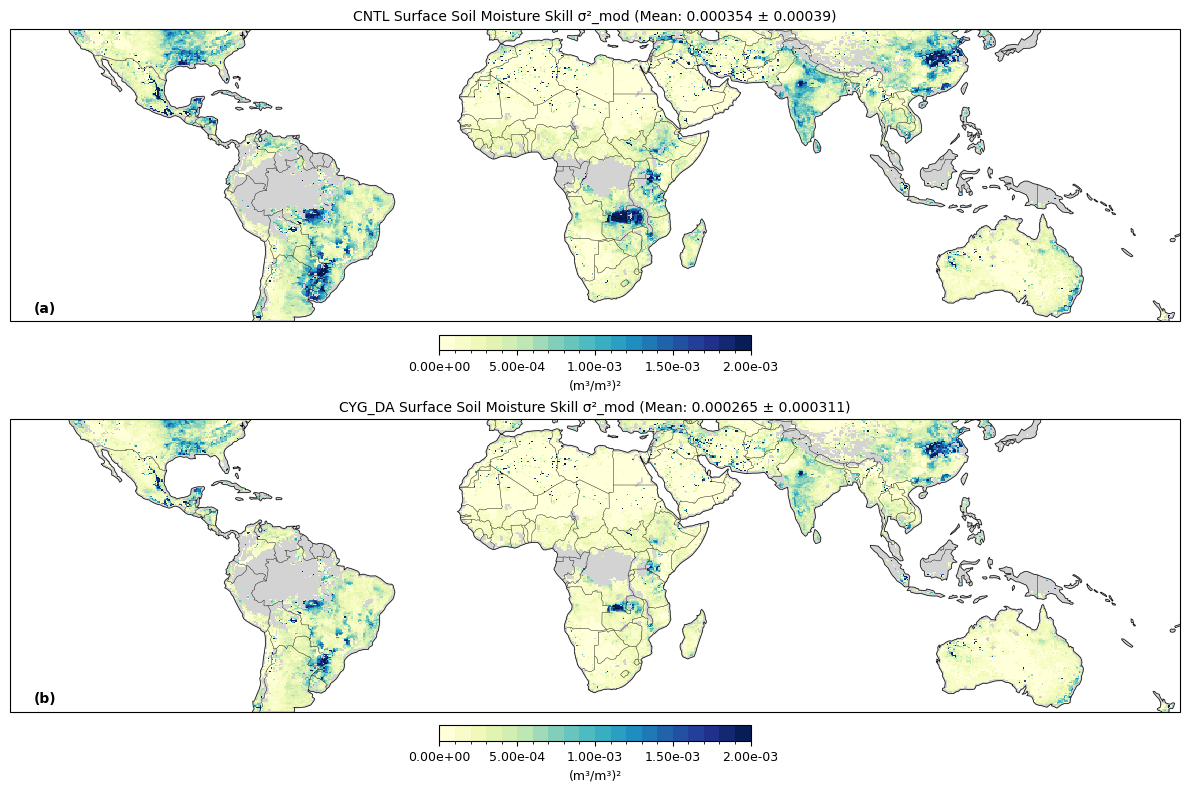

In [38]:
# Two-panel: CNTL vs CYG_DA sigma2_mod (same scale)
vals = [
    (S0["sigma2_mod"], 'CNTL Surface Soil Moisture Skill σ²_mod', '(a)'),
    (S1["sigma2_mod"], 'CYG_DA Surface Soil Moisture Skill σ²_mod', '(b)'),
]

lats_ease, lons_ease = load_ease_grid(); lats_row, lons_col = lats_ease[:,1], lons_ease[1,:]
lon_grid, lat_grid = np.meshgrid(lons_col, lats_row)
map_array_tmp = np.empty([lons.size, 3]); map_array_tmp.fill(np.nan); map_array_tmp[:,1] = lons.flatten(); map_array_tmp[:,2] = lats.flatten()

vmin, vmax = 0.0, 2e-3
edges = np.linspace(vmin, vmax, 21)
cmap = get_cmap('YlGnBu', len(edges) - 1)
norm = BoundaryNorm(edges, cmap.N)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, (data_grid, title, lab) in zip(axes, vals):
    data_grid = np.asarray(data_grid)
    data_grid = np.where(np.isfinite(data_grid), np.clip(data_grid, vmin, vmax), np.nan)
    data_flat = data_grid.flatten()
    mean_val = np.nanmean(data_flat); std_val = np.nanstd(data_flat)
    map_array_tmp[:,0] = data_flat
    grid = build_ease_grid_mapping(map_array_tmp, lats_row, lons_col)
    sc = ax.pcolormesh(lon_grid, lat_grid, grid, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=0)
    ax.set_extent(REGION_BOUNDS['cygnss'], crs=ccrs.PlateCarree())
    ax.set_title(f"{title} (Mean: {mean_val:.3g} ± {std_val:.3g})", fontsize=10)
    ax.text(0.02, 0.02, lab, transform=ax.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')
    ax.tick_params(labelbottom=False, labelleft=False)
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.04, fraction=0.046)
    cbar.set_label('(m³/m³)²', fontsize=9)
    cbar.set_ticks(edges[::5])
    cbar.ax.set_xticklabels([f"{t:.2e}" for t in edges[::5]])
    cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()
